# Abstract

This notebook contains the source code for the _"News Stance Detection"_ project of __"COMPGI15 Information Retrieval & Data Mining"__. The notebook is organized in nine sections, each section corresponding to an assignment's quetion.

- [__Q1. Train - Validation split:__](#question1) Split training set into a training and validation set with ratio 9:1. Each subset has a similar proportion of every stance.
- [__Q2. Vector Representation:__](#question2) We extract vector representations of headline and bodies and compute the cosine similarity between those vectors. We implemented Bag of Words (BoW) and Tf-Idf from scratch. We also use gensim's Word2Vec model.
- [__Q3. Language Model:__](#question3) Establish language model based representations of headlines and bodies.
- [__Q4. Feature Engineering:__](#question4) We propose and implement alternative features and distances.
- [__Q5. Feature Exploration:__](#question5) We explore the distribution of the new distances for all vector representation models, as well as the distribution of the new global features, per stance.
- [__Q6. Linear and Logistic Regression:__](#question6) We implement Linear and Logistic Regression with Gradient Descent from scratch and train the models based on the features from Q5. Since we have to deal with a multi-class problem, One-VS-Rest (OVR) Logistic Regression is implemented.
- [__Q7. Model Evaluation:__](#question7) We use three metrics to evaluate our models: The official evaluation metric of FNC-1 (+0.25 for correct classification between related and unrelated, +0.75 for correct classification between agree, disagree and discuss stances), weighted F1-score (and F1-score per stance) and confusion matrices.
- [__Q8. Feature Importance:__](#question8) We use the predicted weights of the separating hyperplanes per stance to see which are the most important features for stance classification.
- [__Q9. Model Improvement:__](#question9) We oversample the minority classes (agree, disagree and discuss) with SMOTE and try three different models (using off-the-shell packages), namely Random Forest, XGBoost and Multilyer Perceptron. All of these models outperform the oof and test FNC-1 baseline models.

## Import Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

# Set a random seed for repeatability
rand_seed = 123
random.seed(rand_seed)
np.random.seed(rand_seed)

% matplotlib inline

In [2]:
start_total = time.time()

In [3]:
train_bodies = pd.read_csv("data/train_bodies.csv")
train_stances = pd.read_csv("data/train_stances.csv")
test_bodies = pd.read_csv("data/competition_test_bodies.csv")
test_stances = pd.read_csv("data/competition_test_stances.csv")

In [4]:
train_bodies.shape, train_stances.shape, test_bodies.shape, test_stances.shape

((1683, 2), (49972, 3), (904, 2), (25413, 3))

In [5]:
train_bodies.columns, train_stances.columns

(Index(['Body ID', 'articleBody'], dtype='object'),
 Index(['Headline', 'Body ID', 'Stance'], dtype='object'))

In [6]:
train_bodies["articleBody"][0]

'A small meteorite crashed into a wooded area in Nicaragua\'s capital of Managua overnight, the government said Sunday. Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city\'s airport, the Associated Press reports. \n\nGovernment spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a "relatively small" meteorite that "appears to have come off an asteroid that was passing close to Earth." House-sized asteroid 2014 RC, which measured 60 feet in diameter, skimmed the Earth this weekend, ABC News reports. \nMurillo said Nicaragua will ask international experts to help local scientists in understanding what happened.\n\nThe crater left by the meteorite had a radius of 39 feet and a depth of 16 feet,  said Humberto Saballos, a volcanologist with the Nicaraguan Institute of Territorial Studies who was on the committee. He said it is still not clear if the meteorite disintegrated or was buried.\n\nHumbe

In [7]:
len(np.unique(train_stances["Headline"])), len(np.unique(train_bodies["articleBody"]))

(1648, 1669)

In [8]:
train_stances["Stance"].value_counts()

unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: Stance, dtype: int64

In [9]:
train_stances["Stance"].value_counts() / train_stances.shape[0]

unrelated    0.731310
discuss      0.178280
agree        0.073601
disagree     0.016809
Name: Stance, dtype: float64

# Q1. Split train to train and validation <a id='question1'></a>

In [10]:
def joinText(df):
    
    """
    Joins the headline and body to create a single text. This unified text will be used then as input
    for the creation of the vocabulary and feature extraction.
    """
    return ". ".join((df["Headline"], df["articleBody"]))


def TrainValidationSplit(train_stances, train_bodies):
    
    """
    This function takes as input the training set stances and bodies, merges to a single dataset and
    splits dataset to traing and validation set with a 9:1 ratio per stance
    """
    
    # Join datasets
    train = pd.merge(train_stances, train_bodies, on = "Body ID", how = "left")
    
    # Join headline and body to use afterwards in vectorization
    train["headlineBody"] = train[["Headline", "articleBody"]].apply(joinText, axis=1)
    train = train[["Body ID", "Headline", "articleBody", "headlineBody", "Stance"]]

    
    # Seperate stances and shuffle for randomness
    data_agree = train.loc[train["Stance"] == "agree"].sample(frac = 1, random_state = rand_seed)
    data_disagree = train.loc[train["Stance"] == "disagree"].sample(frac = 1, random_state = rand_seed)
    data_discuss = train.loc[train["Stance"] == "discuss"].sample(frac = 1, random_state = rand_seed)
    data_unrelated = train.loc[train["Stance"] == "unrelated"].sample(frac = 1, random_state = rand_seed)
    
    # Split train and validation per category
    train_agree = data_agree[:int(0.9*data_agree.shape[0])]
    validation_agree = data_agree[int(0.9*data_agree.shape[0]): ]
    
    train_disagree = data_disagree[:int(0.9*data_disagree.shape[0])]
    validation_disagree = data_disagree[int(0.9*data_disagree.shape[0]): ]
    
    train_discuss = data_discuss[:int(0.9*data_discuss.shape[0])]
    validation_discuss = data_discuss[int(0.9*data_discuss.shape[0]): ]
    
    train_unrelated = data_unrelated[:int(0.9*data_unrelated.shape[0])]
    validation_unrelated = data_unrelated[int(0.9*data_unrelated.shape[0]): ]
    
    # Merge datasets
    train = pd.concat([train_agree, train_disagree, train_discuss, train_unrelated])
    validation = pd.concat([validation_agree, validation_disagree, validation_discuss, validation_unrelated])
    
    # Shuffle and reset index
    train = train.sample(frac = 1, random_state = rand_seed).reset_index(drop = True)
    validation = validation.sample(frac = 1, random_state = rand_seed).reset_index(drop = True)
    
    return train, validation

In [11]:
train, validation = TrainValidationSplit(train_stances, train_bodies)

In [12]:
train.shape, validation.shape

((44974, 5), (4998, 5))

In [13]:
train.head()

,Body ID,Headline,articleBody,headlineBody,Stance
0,1883,Nigeria says it has deal with Boko Haram to re...,A trip to Bali has turned Dylan Thomas into a ...,Nigeria says it has deal with Boko Haram to re...,unrelated
1,304,Man Known as ‘Jihadi John’ Is Identified as Mo...,"The 45 year old Mexican/American, born in De l...",Man Known as ‘Jihadi John’ Is Identified as Mo...,unrelated
2,1009,Islamic State releases video apparently showin...,"The recording, allegedly made near the shootin...",Islamic State releases video apparently showin...,unrelated
3,2471,'No hard evidence' of Isis claims it kidnapped...,Gill Rosenberg is reported to have been captur...,'No hard evidence' of Isis claims it kidnapped...,discuss
4,1769,"ISIS Claims an American Hostage, Kayla Mueller...","First up, users had sleepless nights over whet...","ISIS Claims an American Hostage, Kayla Mueller...",unrelated


In [14]:
train["Stance"].value_counts()

unrelated    32890
discuss       8018
agree         3310
disagree       756
Name: Stance, dtype: int64

In [15]:
validation["Stance"].value_counts()

unrelated    3655
discuss       891
agree         368
disagree       84
Name: Stance, dtype: int64

In [16]:
train["Stance"].value_counts() / validation["Stance"].value_counts()

unrelated    8.998632
discuss      8.998878
agree        8.994565
disagree     9.000000
Name: Stance, dtype: float64

In [17]:
ratio_df = pd.concat([train["Stance"].value_counts().to_frame().rename(columns = {"Stance": "Train_Stance"}),
                      validation["Stance"].value_counts().to_frame().rename(columns = {"Stance": "Validation_Stance"})],
                     axis = 1)
ratio_df["ratio"] = ratio_df["Train_Stance"] / ratio_df["Validation_Stance"]

In [18]:
ratio_df

,Train_Stance,Validation_Stance,ratio
unrelated,32890,3655,8.998632
discuss,8018,891,8.998878
agree,3310,368,8.994565
disagree,756,84,9.000000


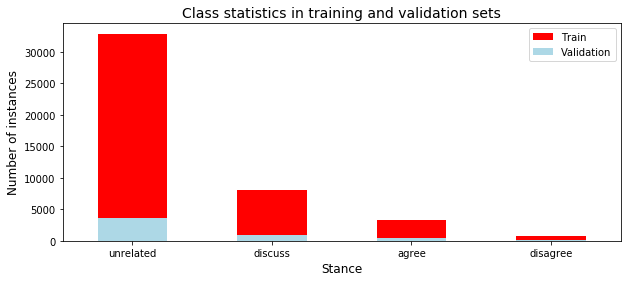

In [19]:
plt.figure(figsize = (10,4))
ratio_df["Train_Stance"].plot(kind = "bar", color = "r")
ratio_df["Validation_Stance"].plot(kind = "bar", color = "lightblue")
plt.xlabel("Stance", fontsize = 12)
plt.ylabel("Number of instances", fontsize = 12)
plt.xticks(rotation=0)
plt.title("Class statistics in training and validation sets", fontsize = 14)
plt.legend(["Train", "Validation"])

# Q2. Vector representations <a id='question2'></a>

In [20]:
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.punkt import PunktSentenceTokenizer
#from nltk.stem.snowball import SnowballStemmer, PorterStemmer
import string
import itertools
from collections import Counter, OrderedDict
import operator
from scipy.spatial.distance import cosine
from sklearn.externals import joblib

In [21]:
# Download nltk packages
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sherlock/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sherlock/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/sherlock/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
def preprocessText(text):
    
    # Lowercase
    text = text.lower()
    
    # Keep only alphabetical characters
    text = re.sub("[^a-zA-Z]+", " ", text)
    
    # Remove extra whitespaces
    #text = text.strip()
    text = " ".join(text.split())
    
    # Remove stopwords
    stopwords = nltk.corpus.stopwords.words("english")
    text = [word for word in text.split() if word not in stopwords]
    
    # Lemmatizing
    wordnet_lemmatizer = WordNetLemmatizer()
    text = [wordnet_lemmatizer.lemmatize(tok) for tok in text]
#     stemmer = SnowballStemmer("english")
#     text = [stemmer.stem(tok) for tok in text]
    
    return text

In [23]:
% time corpus = [preprocessText(text) for text in train["headlineBody"]]

CPU times: user 1min 56s, sys: 7.1 s, total: 2min 3s
Wall time: 5min 21s


In [24]:
% time corpus_headline = [preprocessText(text) for text in train["Headline"]]

CPU times: user 21.2 s, sys: 7.32 s, total: 28.6 s
Wall time: 3min 45s


In [25]:
% time corpus_body = [preprocessText(text) for text in train["articleBody"]]

CPU times: user 1min 52s, sys: 7.28 s, total: 1min 59s
Wall time: 5min 17s


In [26]:
len(corpus_headline),  len(corpus_body)

(44974, 44974)

In [27]:
def createVocabulary(corpus = corpus, max_features = None, preprocessor = preprocessText):
    
    """
    Inputs:
        -- corpus: A list of lists containing the preprocessed (tokenized + stemmed) text
        -- max_features: Determines the size of the vocabulary
    Outputs:
        -- created vocabulary
        
    Unit test: corpus = [
                         ['This', 'is', 'the', 'first', 'document.'],
                         ['This', 'is', 'the', 'second', 'second' ,'document.'],
                         ['And', 'the', 'third', 'one.'],
                         ['Is', 'this', 'the', 'first', 'document?'],
                        ]
    """
    

    # Combine list of lists to a single list
    all_words = list(itertools.chain.from_iterable(corpus))
    
    # Count word occurence
    voc = Counter(all_words) 
    
    # Sort dictionary by number of word occurences in ascending order
    voc_sorted = OrderedDict(sorted(voc.items(), key=operator.itemgetter(1), reverse = True))
    
    # Return top <max_features> words
    if max_features:
        voc_final = list(voc_sorted.keys())[:max_features]
    else:
        voc_final = list(voc_sorted.keys())
    
    return voc_final, voc_sorted



def BoW(corpus = corpus, vocabulary = []):
    
    # Initialize BoW matrix with dimensions (n_documents, voc_size)
    bow_matrix = np.zeros([len(corpus), len(vocabulary)])
    
    # For each word in vocabulary find number of occurences per document
    i = 0
    for doc in corpus:
        bow_matrix[i,:] = [doc.count(word) for word in vocabulary]
        i+=1
        
    return bow_matrix



def tfidf(corpus = corpus, vocabulary = []):
    
    # Calculate word counts
    bow_matrix = BoW(corpus = corpus, vocabulary = vocabulary)
    
    # Map every word count >=1 to 1, to calculate number of documents that contain each term of vocabulary
    bow_matrix_binary = bow_matrix
    bow_matrix_binary[bow_matrix_binary >= 1] = 1
    
    # Calculate idf
    idf = np.log10((1+bow_matrix.shape[0]) / (1 + np.sum(bow_matrix_binary, axis = 0)))
    
    # TFIDF matrix
    tfidf_matrix = bow_matrix*idf
    
    # L2-norm
    tfidf_matrix = tfidf_matrix / np.linalg.norm(tfidf_matrix, ord = 2, axis = 1)[:, np.newaxis]
    
    return tfidf_matrix
    

In [28]:
def cosineSimilarity(u,v):
    
    """
    Calculates the cosine similarity of 1D vectors u, v
    """
    
    dot_product = np.dot(u,v)
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    
    return dot_product / (norm_u * norm_v)


def calculateSimilarity(headline_vector, body_vector, similarityFunction):
    
    sim = [similarityFunction(headline_vector[i], body_vector[i]) for i in range(len(body_vector))]
    return sim

In [29]:
% time voc, _ = createVocabulary(corpus, max_features = 300, preprocessor = preprocessText)

CPU times: user 2.09 s, sys: 40 ms, total: 2.13 s
Wall time: 2.11 s


In [30]:
voc[:20]

['said',
 'u',
 'state',
 'video',
 'one',
 'report',
 'isi',
 'year',
 'apple',
 'time',
 'would',
 'people',
 'also',
 'told',
 'say',
 'new',
 'group',
 'man',
 'news',
 'islamic']

In [31]:
len(voc)

300

## BoW

In [32]:
% time bow_headline = BoW(corpus = corpus_headline, vocabulary = voc)

CPU times: user 3.83 s, sys: 40 ms, total: 3.87 s
Wall time: 3.87 s


In [33]:
% time bow_body = BoW(corpus = corpus_body, vocabulary = voc)

CPU times: user 45.3 s, sys: 0 ns, total: 45.3 s
Wall time: 45.3 s


In [34]:
# joblib.dump(bow_headline, "bow_headline.pkl")
# joblib.dump(bow_body, "bow_body.pkl")

In [35]:
bow_headline.shape, bow_body.shape

((44974, 300), (44974, 300))

In [36]:
sim = [cosineSimilarity(bow_headline[i], bow_body[i]) for i in range(len(bow_body))]
train["bow_similarity"] = sim

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars


In [37]:
train["bow_similarity"].isnull().sum()

3077

In [38]:
train[train.isnull().any(axis=1)]["Stance"].value_counts()

unrelated    2289
agree         375
discuss       358
disagree       55
Name: Stance, dtype: int64

In [39]:
train.loc[ train["bow_similarity"] == 0].shape

(20023, 6)

In [40]:
train["Stance"].value_counts()

unrelated    32890
discuss       8018
agree         3310
disagree       756
Name: Stance, dtype: int64

In [41]:
train.loc[ train["bow_similarity"] == 0]["Stance"].value_counts() / train["Stance"].value_counts()

unrelated    0.583916
discuss      0.051384
agree        0.095770
disagree     0.117725
Name: Stance, dtype: float64

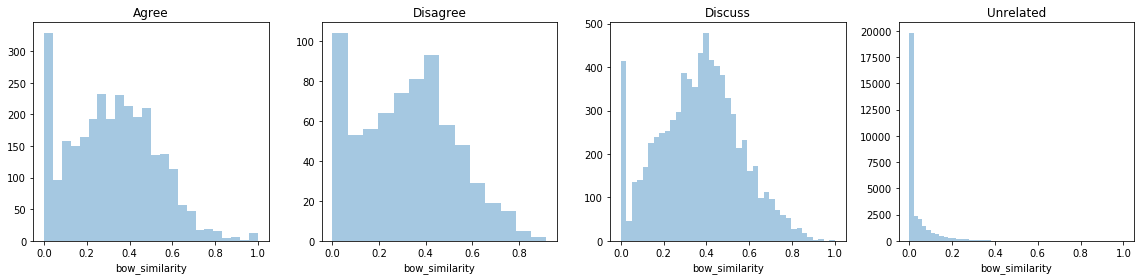

In [42]:
plt.figure(figsize = (16,4))
flag1 = True
flag2 = False

plt.subplot(1,4,1)
sns.distplot(train.loc[train["Stance"] == "agree"]["bow_similarity"].dropna(), hist = flag1, kde = flag2)
plt.title("Agree")

plt.subplot(1,4,2)
sns.distplot(train.loc[train["Stance"] == "disagree"]["bow_similarity"].dropna(), hist = flag1, kde = flag2)
plt.title("Disagree")

plt.subplot(1,4,3)
sns.distplot(train.loc[train["Stance"] == "discuss"]["bow_similarity"].dropna(), hist = flag1, kde = flag2)
plt.title("Discuss")

plt.subplot(1,4,4)
sns.distplot(train.loc[train["Stance"] == "unrelated"]["bow_similarity"].dropna(), hist = flag1, kde = flag2)
plt.title("Unrelated")

plt.tight_layout()

## TF-IDF Vectorizer

In [43]:
% time tfidf_headline = tfidf(corpus = corpus_headline, vocabulary = voc)

CPU times: user 3.99 s, sys: 360 ms, total: 4.35 s
Wall time: 4.2 s


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:69: RuntimeWarning: invalid value encountered in true_divide


In [44]:
% time tfidf_body = tfidf(corpus = corpus_body, vocabulary = voc)

CPU times: user 45.3 s, sys: 300 ms, total: 45.6 s
Wall time: 45.7 s


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:69: RuntimeWarning: invalid value encountered in true_divide


In [45]:
# joblib.dump(tfidf_headline, "tfidf_headline.pkl")
# joblib.dump(tfidf_body, "tfidf_body.pkl")

In [46]:
tfidf_headline.shape, tfidf_body.shape

((44974, 300), (44974, 300))

In [47]:
tfidf_sim = [cosineSimilarity(tfidf_headline[i], tfidf_body[i]) for i in range(len(bow_body))]
train["tfidf_similarity"] = tfidf_sim

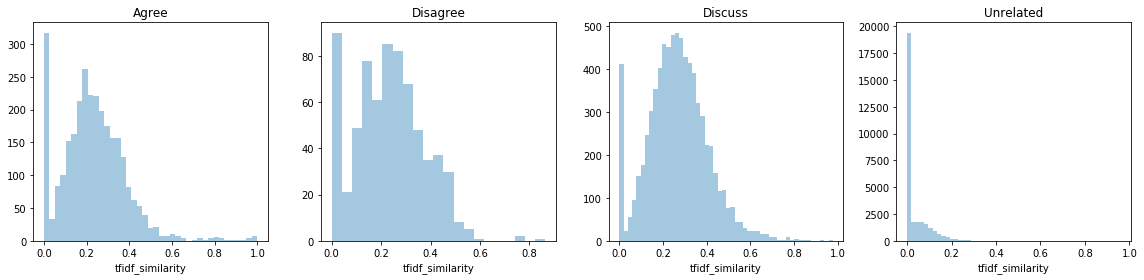

In [48]:
plt.figure(figsize = (16,4))
flag1 = True
flag2 = False

plt.subplot(1,4,1)
sns.distplot(train.loc[train["Stance"] == "agree"]["tfidf_similarity"].dropna(), hist = flag1, kde = flag2)
plt.title("Agree")

plt.subplot(1,4,2)
sns.distplot(train.loc[train["Stance"] == "disagree"]["tfidf_similarity"].dropna(), hist = flag1, kde = flag2)
plt.title("Disagree")

plt.subplot(1,4,3)
sns.distplot(train.loc[train["Stance"] == "discuss"]["tfidf_similarity"].dropna(), hist = flag1, kde = flag2)
plt.title("Discuss")

plt.subplot(1,4,4)
sns.distplot(train.loc[train["Stance"] == "unrelated"]["tfidf_similarity"].dropna(), hist = flag1, kde = flag2)
plt.title("Unrelated")

plt.tight_layout()

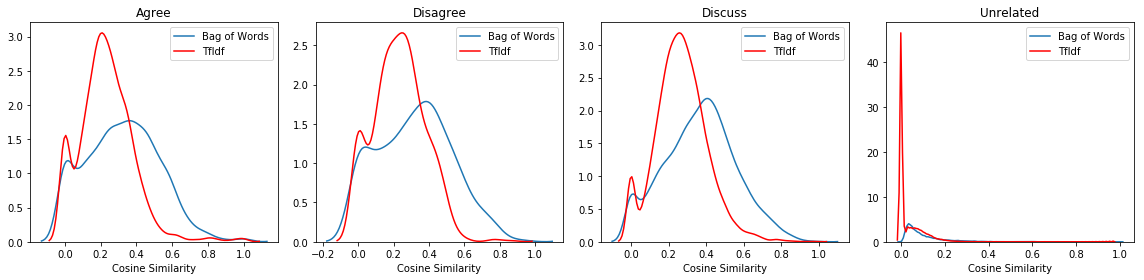

In [49]:
plt.figure(figsize = (16,4))

plt.subplot(1,4,1)
sns.distplot(train.loc[train["Stance"] == "agree"]["bow_similarity"].dropna(), hist = False, label = "Bag of Words")
sns.distplot(train.loc[train["Stance"] == "agree"]["tfidf_similarity"].dropna(), hist = False, color = "r", label = "TfIdf")
plt.xlabel("Cosine Similarity")
plt.title("Agree")

plt.subplot(1,4,2)
sns.distplot(train.loc[train["Stance"] == "disagree"]["bow_similarity"].dropna(), hist = False, label = "Bag of Words")
sns.distplot(train.loc[train["Stance"] == "disagree"]["tfidf_similarity"].dropna(), hist = False, color = "r", label = "TfIdf")
plt.xlabel("Cosine Similarity")
plt.title("Disagree")

plt.subplot(1,4,3)
sns.distplot(train.loc[train["Stance"] == "discuss"]["bow_similarity"].dropna(), hist = False, label = "Bag of Words")
sns.distplot(train.loc[train["Stance"] == "discuss"]["tfidf_similarity"].dropna(), hist = False, color = "r", label = "TfIdf")
plt.xlabel("Cosine Similarity")
plt.title("Discuss")

plt.subplot(1,4,4)
sns.distplot(train.loc[train["Stance"] == "unrelated"]["bow_similarity"].dropna(), hist = False, label = "Bag of Words")
sns.distplot(train.loc[train["Stance"] == "unrelated"]["tfidf_similarity"].dropna(), hist = False, color = "r", label = "TfIdf")
plt.xlabel("Cosine Similarity")
plt.title("Unrelated")

plt.tight_layout()

## Word2Vec

In [50]:
from gensim.models import Word2Vec
import time

In [51]:
def preprocessTextWV(text):
    
    # Lowercase
    text = text.lower()
    
    # Keep only alphabetical characters
    text = re.sub("[^a-zA-Z]+", " ", text)
    
    # Remove extra whitespaces
    #text = text.strip()
    text = " ".join(text.split())
    
    # Remove stopwords and useless words
    stopwords = nltk.corpus.stopwords.words("english")
    text = [word for word in text.split() if word not in stopwords]
    
    return text

In [52]:
def splitToSentences(data):
    
    """
    Takes as input headline or body, tokenizes text to sentences and creates a new dataset where
    each element is a sentence. This is because Word2Vec expects as input a list of sentences
    (e.g. a list of lists where each list is a sentence)
    """

    # Initialize tokenizer
    tokenizer = PunktSentenceTokenizer()
    
    # Sentences
    sent = []
    
    tokenized = [tokenizer.tokenize(doc) for doc in data] #splits text into sentences
    for doc in tokenized:
        for sentence in doc:
            sent.append(sentence)
            
    # Remove empty sentences
    sent = [sentence for sentence in sent if len(sentence) > 1]
    
    # Preprocess text
    
    ## Lowercase
    sent = [text.lower() for text in sent]
    
    ## Keep only alphabetical characters
    sent =  [re.sub("[^a-zA-Z]+", " ", text) for text in sent]
    
    # Remove stopwords and useless words
    stopwords = nltk.corpus.stopwords.words("english")
    sent = [[word for word in text.split() if word not in stopwords] for text in sent]
    
    # Tokenize each sentence
    #sent = [sentence.split() for sentence in sent]
    
    return sent

In [53]:
% time corpus_wv = splitToSentences(train["headlineBody"])

CPU times: user 1min 19s, sys: 752 ms, total: 1min 20s
Wall time: 1min 20s


In [54]:
len(corpus_wv)

823023

In [55]:
% time model = Word2Vec(corpus_wv, size = 300, min_count=1)

CPU times: user 2min 36s, sys: 280 ms, total: 2min 36s
Wall time: 55.2 s


In [56]:
model.wv.vectors.shape

(22362, 300)

In [57]:
wv_vocab = list(model.wv.vocab)
len(wv_vocab)

22362

In [58]:
model.wv["wings"].shape

(300,)

In [59]:
def getAverageVector(text):
    
    matrix = [model.wv[word] for word in text.split() if word in list(model.wv.vocab)]
    matrix = np.array(matrix)
    
    if len(matrix) > 1:
        avg_vector = np.mean(matrix, axis = 0)
    else:
        avg_vector = np.zeros(model.wv.vectors.shape[1])
        
    return avg_vector

def Word2Vec_Model(corpus):
    
    a = np.empty((0, model.wv.vectors.shape[1]))
    
    for doc in corpus:
        a = np.vstack((a, getAverageVector(doc)))
        
    return a

In [175]:
# a = getAverageVector(train["Headline"][0])
# a.shape, a

In [61]:
#% time X_wv_headline = Word2Vec_Model(corpus_headline)

In [62]:
X_wv_headline = joblib.load("X_wv_headline.pkl")

In [63]:
X_wv_headline.shape

(44974, 300)

In [64]:
def clipBody(body):
    
    """
    Tokenizes article body into sentences and based upon the intuition that a human writer would use strong indicators of agreement/
    disagreement in the initial or last few sentences, we only included the first and last 5 sentences of the body.
    """
    
    # Initialize tokenizer
    tokenizer = PunktSentenceTokenizer()
    
    #
    clipped_text = []
    for doc in body:
        tok_text = tokenizer.tokenize(doc)
        clipped_text.append("".join(tok_text[:6] + tok_text[-6:]))
        
    return pd.Series(clipped_text)

In [65]:
corpus_body_clipped = clipBody(train["articleBody"])

In [66]:
#% time X_wv_body = Word2Vec_Model(corpus_body_clipped)

In [67]:
X_wv_body = joblib.load("X_wv_body.pkl")

In [68]:
X_wv_body.shape

(44974, 300)

In [69]:
#joblib.dump(X_wv_headline, "X_wv_headline.pkl")
#joblib.dump(X_wv_body, "X_wv_body.pkl")

In [70]:
wv_sim = [cosineSimilarity(X_wv_headline[i], X_wv_body[i]) for i in range(X_wv_body.shape[0])]
train["wv_similarity"] = wv_sim

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars


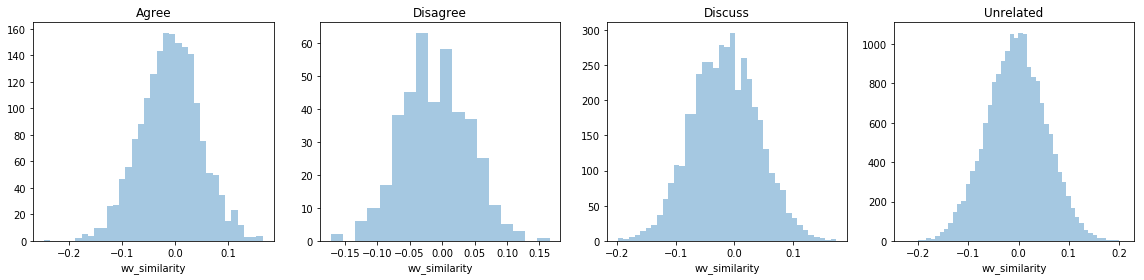

In [71]:
plt.figure(figsize = (16,4))
flag1 = True
flag2 = False

plt.subplot(1,4,1)
sns.distplot(train.loc[train["Stance"] == "agree"]["wv_similarity"].dropna(), hist = flag1, kde = flag2)
plt.title("Agree")

plt.subplot(1,4,2)
sns.distplot(train.loc[train["Stance"] == "disagree"]["wv_similarity"].dropna(), hist = flag1, kde = flag2)
plt.title("Disagree")

plt.subplot(1,4,3)
sns.distplot(train.loc[train["Stance"] == "discuss"]["wv_similarity"].dropna(), hist = flag1, kde = flag2)
plt.title("Discuss")

plt.subplot(1,4,4)
sns.distplot(train.loc[train["Stance"] == "unrelated"]["wv_similarity"].dropna(), hist = flag1, kde = flag2)
plt.title("Unrelated")

plt.tight_layout()

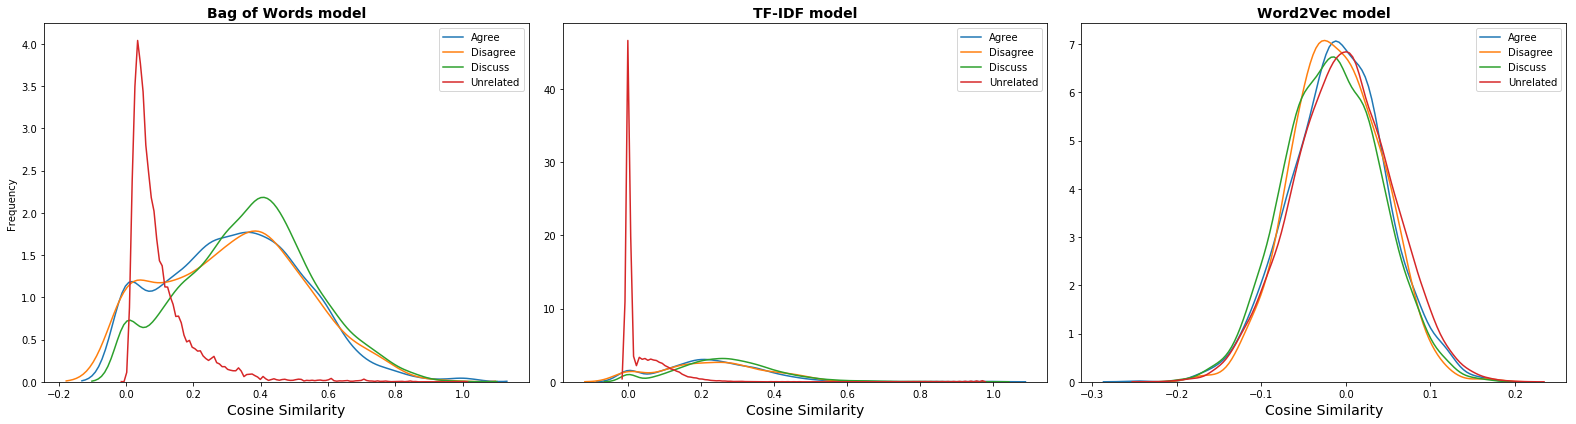

In [72]:
plt.figure(figsize = (22,6))

flag1 = False
flag2 = True

plt.subplot(1,3,1)
sns.distplot(train.loc[train["Stance"] == "agree"]["bow_similarity"].dropna(), hist = flag1, kde = flag2, label = "Agree")
sns.distplot(train.loc[train["Stance"] == "disagree"]["bow_similarity"].dropna(), hist = flag1, kde = flag2, label = "Disagree")
sns.distplot(train.loc[train["Stance"] == "discuss"]["bow_similarity"].dropna(), hist = flag1, kde = flag2, label = "Discuss")
sns.distplot(train.loc[train["Stance"] == "unrelated"]["bow_similarity"].dropna(), hist = flag1, kde = flag2, label = "Unrelated")
plt.xlabel("Cosine Similarity", fontsize = 14)
plt.ylabel("Frequency")
plt.title("Bag of Words model", fontsize = 14, fontweight = "bold")

plt.subplot(1,3,2)
sns.distplot(train.loc[train["Stance"] == "agree"]["tfidf_similarity"].dropna(), hist = flag1, kde = flag2, label = "Agree")
sns.distplot(train.loc[train["Stance"] == "disagree"]["tfidf_similarity"].dropna(), hist = flag1, kde = flag2, label = "Disagree")
sns.distplot(train.loc[train["Stance"] == "discuss"]["tfidf_similarity"].dropna(), hist = flag1, kde = flag2, label = "Discuss")
sns.distplot(train.loc[train["Stance"] == "unrelated"]["tfidf_similarity"].dropna(), hist = flag1, kde = flag2, label = "Unrelated")
plt.xlabel("Cosine Similarity", fontsize = 14)
plt.title("TF-IDF model", fontsize = 14, fontweight = "bold")

plt.subplot(1,3,3)
sns.distplot(train.loc[train["Stance"] == "agree"]["wv_similarity"].dropna(), hist = flag1, kde = flag2, label = "Agree")
sns.distplot(train.loc[train["Stance"] == "disagree"]["wv_similarity"].dropna(), hist = flag1, kde = flag2, label = "Disagree")
sns.distplot(train.loc[train["Stance"] == "discuss"]["wv_similarity"].dropna(), hist = flag1, kde = flag2, label = "Discuss")
sns.distplot(train.loc[train["Stance"] == "unrelated"]["wv_similarity"].dropna(), hist = flag1, kde = flag2, label = "Unrelated")
plt.xlabel("Cosine Similarity", fontsize = 14)
plt.title("Word2Vec model", fontsize = 14, fontweight = "bold")

plt.tight_layout()
#plt.savefig("Figures/pic2.png")

# Q3: Language Models <a id='question3'></a>

In [176]:
def queryModel(headline_cleaned, body_cleaned, smoothing = 0.0001):
    
    counts = []
    for word in headline_cleaned:
        counts.append(body_cleaned.count(word))
        
    prob = [(x+smoothing) / len(body_cleaned) for x in counts]
    p_q_md = np.prod(np.array(prob))

    return p_q_md

def documentModel(headline_cleaned, body_cleaned, stance, smoothing = 0.0001, perc = 0.5):
    
    counts = []
    
    for word in body_cleaned:
        if stance in ["agree", "disagree", "discuss"]:
            extra_words = list(np.random.choice(body_cleaned, int(np.round(perc*len(body_cleaned)))))
            headline_cleaned = headline_cleaned + extra_words
        
        counts.append(headline_cleaned.count(word))
        
    prob = [(x+smoothing) / len(headline_cleaned) for x in counts]
    p_d_q = np.prod(np.array(prob))
            
    return p_d_q

def KL_Divergence(u,v):
    
    return v*np.log10(v/u)

In [177]:
% time query_model = [queryModel(corpus_headline[i], corpus_body[i]) for i in range(len(corpus_headline))]

CPU times: user 1.87 s, sys: 0 ns, total: 1.87 s
Wall time: 1.87 s


In [179]:
# % time document_model = [documentModel(corpus_headline[i], corpus_body[i], train["Stance"][i], smoothing = 1, perc = 0.5) for i in range(len(corpus_headline))]
document_model = joblib.load("doc_lm.pkl")

In [ ]:
# train["headline_lm"] = query_model
# train["body_lm"] = document_model

In [180]:
kl_div = [KL_Divergence(query_model[i], document_model[i]) for i in range(len(train["Stance"]))]
train["kl_div"] = kl_div

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in double_scalars


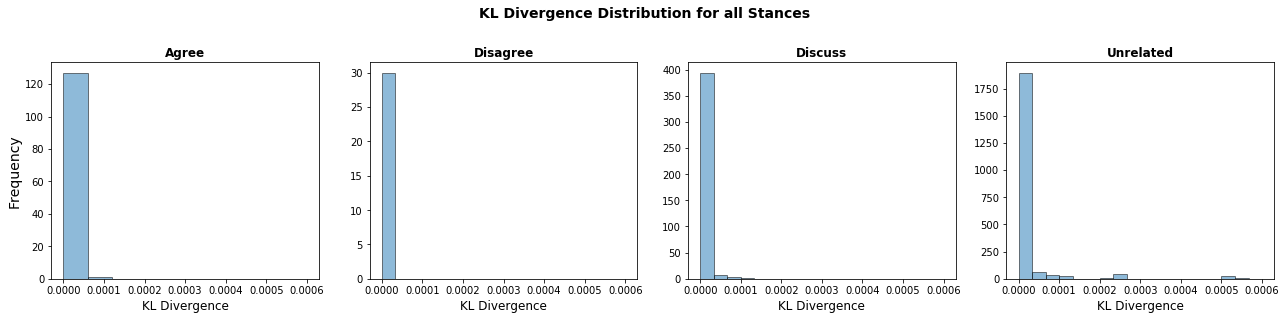

In [198]:
plt.figure(figsize = (18,4))

plt.subplot(1,4,1)
plt.hist(train.loc[train["Stance"] == "agree"]["kl_div"].dropna(), 10, alpha=.5, range=[0, 0.0006], edgecolor = 'black')
plt.title("Agree", fontsize = 12, fontweight = "bold")
plt.xlabel("KL Divergence", fontsize = 12)
plt.ylabel("Frequency", fontsize = 14)

plt.subplot(1,4,2)
plt.hist(train.loc[train["Stance"] == "disagree"]["kl_div"].dropna(), 18, alpha=.5, range=[0, 0.0006], edgecolor = 'black')
plt.title("Disagree", fontsize = 12, fontweight = "bold")
plt.xlabel("KL Divergence", fontsize = 12)

plt.subplot(1,4,3)
plt.hist(train.loc[train["Stance"] == "discuss"]["kl_div"].dropna(), 18, alpha=.5, range=[0, 0.0006], edgecolor = 'black')
plt.title("Discuss", fontsize = 12, fontweight = "bold")
plt.xlabel("KL Divergence", fontsize = 12)

plt.subplot(1,4,4)
plt.hist(train.loc[train["Stance"] == "unrelated"]["kl_div"].dropna(), 18, alpha=.5, range=[0, 0.0006], edgecolor = 'black')
plt.title("Unrelated", fontsize = 12, fontweight = "bold")
plt.xlabel("KL Divergence", fontsize = 12)

plt.tight_layout()
plt.suptitle("KL Divergence Distribution for all Stances", y = 1.1, fontsize = 14, fontweight="bold")
plt.savefig("Figures/KL.png")

# Q4: Feature Engineering <a id='question4'></a>

In [73]:
from nltk import ngrams
from textblob import TextBlob

### Global Features

In [74]:
def ngramOverlap(headline_cleaned, body_cleaned, n):
    
    """
    Calculates the overlapping ratio between headline and body. The overlapping ratio is calculated by finding the common (unique) tokens/ngrams
    for the headline-body pair divided by the total (unique) number of tokens/ngrams generated by the pair. 
    """
    
    overlap_ratio = []
    
    for i in range(len(headline_cleaned)):
        
        headline = list(ngrams(headline_cleaned[i], n))
        body = list(ngrams(body_cleaned[i], n))
        
        try:
            overlap_ratio.append(len(set(headline).intersection(body)) / len(set(headline).union(body)))
        except ZeroDivisionError:
            overlap_ratio.append(0)
    
    return overlap_ratio


def co_occurenceSum(headline_cleaned, body_cleaned):
    
    """
    Counts the number of how often any word in the headline appears in the body.
    """
    
    counts = np.zeros(len(headline_cleaned))
    
    for i, (headline, body) in enumerate(zip(headline_cleaned, body_cleaned)):
        for word in headline:
            if word in body:
                counts[i] += 1
    return counts


def refutingWords(headline_cleaned):
    
    """
    Indicates whether there is a "refuting word" in the body. As "refuting words" we consider those as defined from
    the FNC-1 Baseline Implementation
    """
    
    refuting_words = ["fake", "fraud", "hoax", "false", "deny", "denies", "despite", "nope", "doubt", "doubts",
                      "bogus", "debunk", "pranks", "retract"]
    
    return [1 if len(set(headline).intersection(refuting_words)) > 0 else 0 for headline in headline_cleaned]


def countRefutingWords(body_cleaned):
    
    """
    Instead of just indicating the presence or absence of a "refuting word" in the body, returns the total number
    of "refuting words".
    """
    
    refuting_words = ["fake", "fraud", "hoax", "false", "deny", "denies", "despite", "nope", "doubt", "doubts",
                      "bogus", "debunk", "pranks", "retract"]
    
    count = np.zeros(len(body_cleaned))
    i = 0
    
    for doc in body_cleaned:
        for word in refuting_words:
            if word in doc:
                count[i] += 1
        i+=1
    
    return count


def discussWords(body_cleaned):
    
    """
    Indicates whether there is a "discuss word" in the body. As "discuss words" we consider those as defined from
    the FNC-1 Baseline Implementation
    """
    
    discuss_words = ["according", "maybe", "reporting", "reports", "say", "says", "claim", "claims", "purportedly",
                     "investigating", "told", "tells", "allegedly", "validate", "verify"]
    
    return [1 if len(set(body).intersection(discuss_words)) > 0 else 0 for body in body_cleaned]


def countDiscussWords(body_cleaned):
    
    """
    Instead of just indicating the presence or absence of a "discuss word" in the body, returns the total number
    of "discuss words".
    """
    
    discuss_words = ["according", "maybe", "reporting", "reports", "say", "says", "claim", "claims", "purportedly",
                     "investigating", "told", "tells", "allegedly", "validate", "verify"]
    
    count = np.zeros(len(body_cleaned))
    i = 0
    
    for doc in body_cleaned:
        for word in discuss_words:
            if word in doc:
                count[i] += 1
        i+=1
    
    return count


def PolaritySubjectivity(headline_cleaned, body_cleaned):
    
    """
    Calculates the polarity and subjectivity of headline and body using the sentiment analysis feature of TextBlob package.
    For documentation check the link: "https://github.com/sloria/TextBlob"
    """
    
    polarity_head = [TextBlob(" ".join(doc)).sentiment.polarity for doc in headline_cleaned]
    subjectivity_head = [TextBlob(" ".join(doc)).sentiment.subjectivity for doc in headline_cleaned]
    
    polarity_body = [TextBlob(" ".join(doc)).sentiment.polarity for doc in body_cleaned]
    subjectivity_body = [TextBlob(" ".join(doc)).sentiment.subjectivity for doc in body_cleaned]
    
    return polarity_head, subjectivity_head, polarity_body, subjectivity_body 

### Alternative Distances

In [75]:
def euclideanDistance(a, b):
    return np.sqrt(np.sum((a - b)**2))

def minkowskiDistance(a,b,p):
    return np.sum((a-b)**p)**(1/p)

def manhattanDistance(a,b):
    return np.sum(abs(a-b))

def canberraDistance(a,b):
    dist = abs(a - b) / (abs(a) + abs(b))
    dist = dist[~np.isnan(dist)]
    return np.sum(dist)

In [76]:
def addFeatures(train, headline_cleaned, body_cleaned):
    
    # Overlapping ngrams
    train["overlap_1"] = ngramOverlap(headline_cleaned, body_cleaned, 1)
    train["overlap_2"] = ngramOverlap(headline_cleaned, body_cleaned, 2)
    train["overlap_3"] = ngramOverlap(headline_cleaned, body_cleaned, 3)
    train["overlap_4"] = ngramOverlap(headline_cleaned, body_cleaned, 4)
    
    # Co-occurence
    train["co-occurence"] = co_occurenceSum(headline_cleaned, body_cleaned)
    
    # Refuting words
    train["refuting"] = refutingWords(headline_cleaned)
    
    # Count refuting words
    train["count_refuting_headline"] = countRefutingWords(headline_cleaned) 
    train["count_refuting_body"] = countRefutingWords(body_cleaned)
    
    # Discuss words
    train["count_discuss_words"] = countDiscussWords(body_cleaned)
    
    # Polarity and Subjectivity
    train["headline_polarity"], train["headline_subjectivity"], train["body_polarity"], train["body_subjectivity"] = \
                                                                                                    PolaritySubjectivity(headline_cleaned, body_cleaned)
    
    # Distances
    train["bow_euclidean"] = calculateSimilarity(bow_headline, bow_body, euclideanDistance)
    train["bow_manhattan"] = calculateSimilarity(bow_headline, bow_body, manhattanDistance)
    train["bow_canberra"] = calculateSimilarity(bow_headline, bow_body, canberraDistance)
    
    train["tfidf_euclidean"] = calculateSimilarity(tfidf_headline, tfidf_body, euclideanDistance)
    train["tfidf_manhattan"] = calculateSimilarity(tfidf_headline, tfidf_body, manhattanDistance)
    train["tfidf_canberra"] = calculateSimilarity(tfidf_headline, tfidf_body, canberraDistance)
    
    train["wv_euclidean"] = calculateSimilarity(X_wv_headline, X_wv_body, euclideanDistance)
    train["wv_manhattan"] = calculateSimilarity(X_wv_headline, X_wv_body, manhattanDistance)
    train["wv_canberra"] = calculateSimilarity(X_wv_headline, X_wv_body, canberraDistance)
    
    return train

In [77]:
% time train= addFeatures(train, corpus_headline, corpus_body)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:12: DeprecationWarning: generator 'ngrams' raised StopIteration
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: DeprecationWarning: generator 'ngrams' raised StopIteration
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide


CPU times: user 3min 37s, sys: 728 ms, total: 3min 37s
Wall time: 3min 37s


In [78]:
train.columns

Index(['Body ID', 'Headline', 'articleBody', 'headlineBody', 'Stance',
       'bow_similarity', 'tfidf_similarity', 'wv_similarity', 'overlap_1',
       'overlap_2', 'overlap_3', 'overlap_4', 'co-occurence', 'refuting',
       'count_refuting_headline', 'count_refuting_body', 'count_discuss_words',
       'headline_polarity', 'headline_subjectivity', 'body_polarity',
       'body_subjectivity', 'bow_euclidean', 'bow_manhattan', 'bow_canberra',
       'tfidf_euclidean', 'tfidf_manhattan', 'tfidf_canberra', 'wv_euclidean',
       'wv_manhattan', 'wv_canberra'],
      dtype='object')

# Q5: Feature Exploration <a id='question5'></a>

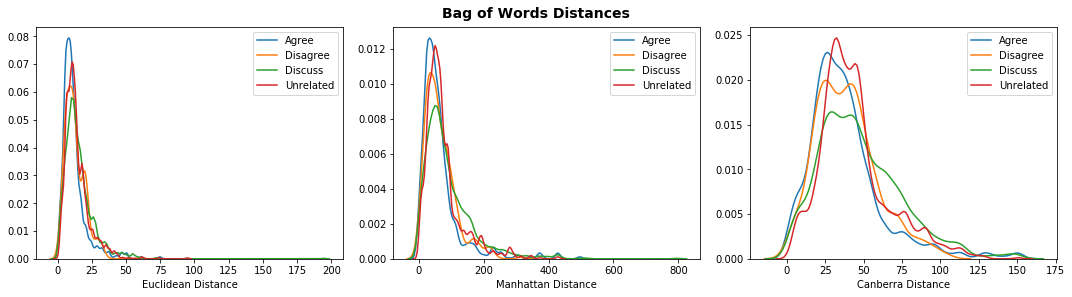

In [79]:
#plt.figure(figsize = (22,4))
plt.figure(figsize = (15,4))

flag1 = False
flag2 = True

plt.subplot(1,3,1)
sns.distplot(train.loc[train["Stance"] == "agree"]["bow_euclidean"].dropna(), hist = flag1, kde = flag2, label = "Agree")
sns.distplot(train.loc[train["Stance"] == "disagree"]["bow_euclidean"].dropna(), hist = flag1, kde = flag2, label = "Disagree")
sns.distplot(train.loc[train["Stance"] == "discuss"]["bow_euclidean"].dropna(), hist = flag1, kde = flag2, label = "Discuss")
sns.distplot(train.loc[train["Stance"] == "unrelated"]["bow_euclidean"].dropna(), hist = flag1, kde = flag2, label = "Unrelated")
plt.xlabel("Euclidean Distance")

plt.subplot(1,3,2)
sns.distplot(train.loc[train["Stance"] == "agree"]["bow_manhattan"].dropna(), hist = flag1, kde = flag2, label = "Agree")
sns.distplot(train.loc[train["Stance"] == "disagree"]["bow_manhattan"].dropna(), hist = flag1, kde = flag2, label = "Disagree")
sns.distplot(train.loc[train["Stance"] == "discuss"]["bow_manhattan"].dropna(), hist = flag1, kde = flag2, label = "Discuss")
sns.distplot(train.loc[train["Stance"] == "unrelated"]["bow_manhattan"].dropna(), hist = flag1, kde = flag2, label = "Unrelated")
plt.xlabel("Manhattan Distance")

plt.subplot(1,3,3)
sns.distplot(train.loc[train["Stance"] == "agree"]["bow_canberra"].dropna(), hist = flag1, kde = flag2, label = "Agree")
sns.distplot(train.loc[train["Stance"] == "disagree"]["bow_canberra"].dropna(), hist = flag1, kde = flag2, label = "Disagree")
sns.distplot(train.loc[train["Stance"] == "discuss"]["bow_canberra"].dropna(), hist = flag1, kde = flag2, label = "Discuss")
sns.distplot(train.loc[train["Stance"] == "unrelated"]["bow_canberra"].dropna(), hist = flag1, kde = flag2, label = "Unrelated")
plt.xlabel("Canberra Distance")

plt.suptitle("Bag of Words Distances", x = 0.5, y = 1.02, fontsize = 14, fontweight="bold")
plt.tight_layout()

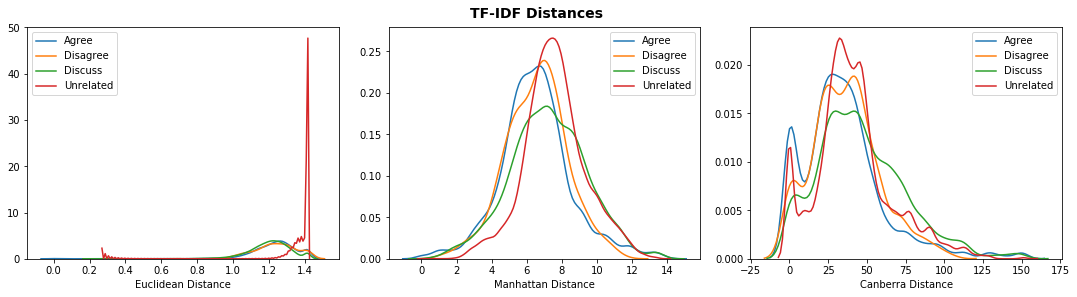

In [80]:
#plt.figure(figsize = (22,4))
plt.figure(figsize = (15,4))

flag1 = False
flag2 = True

plt.subplot(1,3,1)
sns.distplot(train.loc[train["Stance"] == "agree"]["tfidf_euclidean"].dropna(), hist = flag1, kde = flag2, label = "Agree")
sns.distplot(train.loc[train["Stance"] == "disagree"]["tfidf_euclidean"].dropna(), hist = flag1, kde = flag2, label = "Disagree")
sns.distplot(train.loc[train["Stance"] == "discuss"]["tfidf_euclidean"].dropna(), hist = flag1, kde = flag2, label = "Discuss")
sns.distplot(train.loc[train["Stance"] == "unrelated"]["tfidf_euclidean"].dropna(), hist = flag1, kde = flag2, label = "Unrelated")
plt.xlabel("Euclidean Distance")

plt.subplot(1,3,2)
sns.distplot(train.loc[train["Stance"] == "agree"]["tfidf_manhattan"].dropna(), hist = flag1, kde = flag2, label = "Agree")
sns.distplot(train.loc[train["Stance"] == "disagree"]["tfidf_manhattan"].dropna(), hist = flag1, kde = flag2, label = "Disagree")
sns.distplot(train.loc[train["Stance"] == "discuss"]["tfidf_manhattan"].dropna(), hist = flag1, kde = flag2, label = "Discuss")
sns.distplot(train.loc[train["Stance"] == "unrelated"]["tfidf_manhattan"].dropna(), hist = flag1, kde = flag2, label = "Unrelated")
plt.xlabel("Manhattan Distance")

plt.subplot(1,3,3)
sns.distplot(train.loc[train["Stance"] == "agree"]["tfidf_canberra"].dropna(), hist = flag1, kde = flag2, label = "Agree")
sns.distplot(train.loc[train["Stance"] == "disagree"]["tfidf_canberra"].dropna(), hist = flag1, kde = flag2, label = "Disagree")
sns.distplot(train.loc[train["Stance"] == "discuss"]["tfidf_canberra"].dropna(), hist = flag1, kde = flag2, label = "Discuss")
sns.distplot(train.loc[train["Stance"] == "unrelated"]["tfidf_canberra"].dropna(), hist = flag1, kde = flag2, label = "Unrelated")
plt.xlabel("Canberra Distance")

plt.suptitle("TF-IDF Distances", x = 0.5, y = 1.02, fontsize = 14, fontweight="bold")
plt.tight_layout()

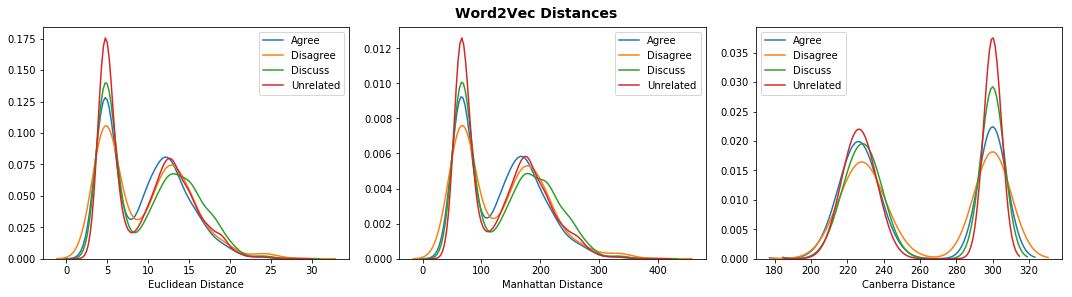

In [81]:
#plt.figure(figsize = (22,4))
plt.figure(figsize = (15,4))

flag1 = False
flag2 = True

plt.subplot(1,3,1)
sns.distplot(train.loc[train["Stance"] == "agree"]["wv_euclidean"].dropna(), hist = flag1, kde = flag2, label = "Agree")
sns.distplot(train.loc[train["Stance"] == "disagree"]["wv_euclidean"].dropna(), hist = flag1, kde = flag2, label = "Disagree")
sns.distplot(train.loc[train["Stance"] == "discuss"]["wv_euclidean"].dropna(), hist = flag1, kde = flag2, label = "Discuss")
sns.distplot(train.loc[train["Stance"] == "unrelated"]["wv_euclidean"].dropna(), hist = flag1, kde = flag2, label = "Unrelated")
plt.xlabel("Euclidean Distance")

plt.subplot(1,3,2)
sns.distplot(train.loc[train["Stance"] == "agree"]["wv_manhattan"].dropna(), hist = flag1, kde = flag2, label = "Agree")
sns.distplot(train.loc[train["Stance"] == "disagree"]["wv_manhattan"].dropna(), hist = flag1, kde = flag2, label = "Disagree")
sns.distplot(train.loc[train["Stance"] == "discuss"]["wv_manhattan"].dropna(), hist = flag1, kde = flag2, label = "Discuss")
sns.distplot(train.loc[train["Stance"] == "unrelated"]["wv_manhattan"].dropna(), hist = flag1, kde = flag2, label = "Unrelated")
plt.xlabel("Manhattan Distance")

plt.subplot(1,3,3)
sns.distplot(train.loc[train["Stance"] == "agree"]["wv_canberra"].dropna(), hist = flag1, kde = flag2, label = "Agree")
sns.distplot(train.loc[train["Stance"] == "disagree"]["wv_canberra"].dropna(), hist = flag1, kde = flag2, label = "Disagree")
sns.distplot(train.loc[train["Stance"] == "discuss"]["wv_canberra"].dropna(), hist = flag1, kde = flag2, label = "Discuss")
sns.distplot(train.loc[train["Stance"] == "unrelated"]["wv_canberra"].dropna(), hist = flag1, kde = flag2, label = "Unrelated")
plt.xlabel("Canberra Distance")

plt.suptitle("Word2Vec Distances", x = 0.5, y = 1.02, fontsize = 14, fontweight="bold")
plt.tight_layout()

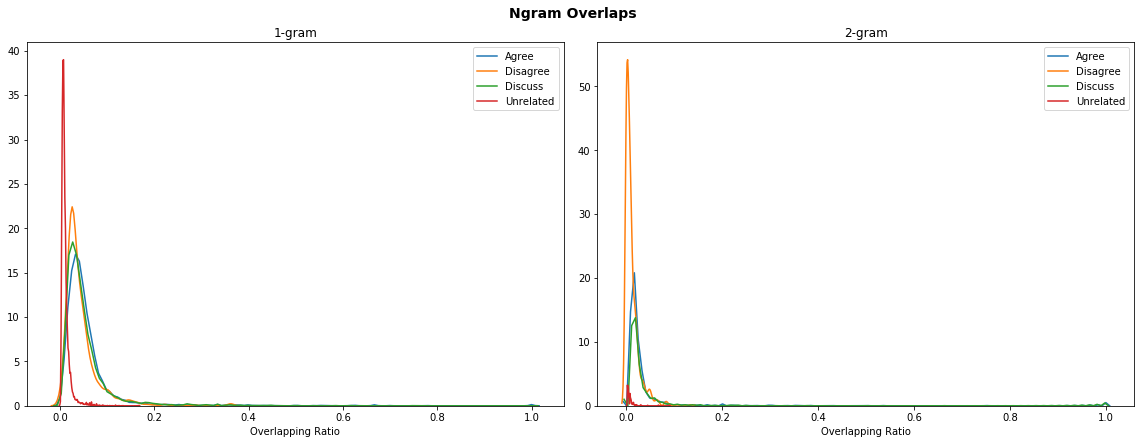

In [82]:
plt.figure(figsize = (16,6))

flag1 = False
flag2 = True

plt.subplot(1,2,1)
sns.distplot(train.loc[train["Stance"] == "agree"]["overlap_1"].dropna(), hist = flag1, kde = flag2, label = "Agree")
sns.distplot(train.loc[train["Stance"] == "disagree"]["overlap_1"].dropna(), hist = flag1, kde = flag2, label = "Disagree")
sns.distplot(train.loc[train["Stance"] == "discuss"]["overlap_1"].dropna(), hist = flag1, kde = flag2, label = "Discuss")
sns.distplot(train.loc[train["Stance"] == "unrelated"]["overlap_1"].dropna(), hist = flag1, kde = flag2, label = "Unrelated")
plt.xlabel("Overlapping Ratio")
plt.title("1-gram")

plt.subplot(1,2,2)
sns.distplot(train.loc[train["Stance"] == "agree"]["overlap_2"].dropna(), hist = flag1, kde = flag2, label = "Agree")
sns.distplot(train.loc[train["Stance"] == "disagree"]["overlap_2"].dropna(), hist = flag1, kde = flag2, label = "Disagree")
sns.distplot(train.loc[train["Stance"] == "discuss"]["overlap_2"].dropna(), hist = flag1, kde = flag2, label = "Discuss")
sns.distplot(train.loc[train["Stance"] == "unrelated"]["overlap_2"].dropna(), hist = flag1, kde = flag2, label = "Unrelated")
plt.xlabel("Overlapping Ratio")
plt.title("2-gram")

# plt.subplot(1,3,3)
# sns.distplot(train.loc[train["Stance"] == "agree"]["overlap_3"].dropna(), hist = flag1, kde = flag2, label = "Agree")
# sns.distplot(train.loc[train["Stance"] == "disagree"]["overlap_3"].dropna(), hist = flag1, kde = flag2, label = "Disagree")
# sns.distplot(train.loc[train["Stance"] == "discuss"]["overlap_3"].dropna(), hist = flag1, kde = flag2, label = "Discuss")
# sns.distplot(train.loc[train["Stance"] == "unrelated"]["overlap_3"].dropna(), hist = flag1, kde = flag2, label = "Unrelated")
# plt.xlabel("Overlapping Ratio")
# plt.title("3-gram")

plt.suptitle("Ngram Overlaps", x = 0.5, y = 1.02, fontsize = 14, fontweight="bold")
plt.tight_layout()

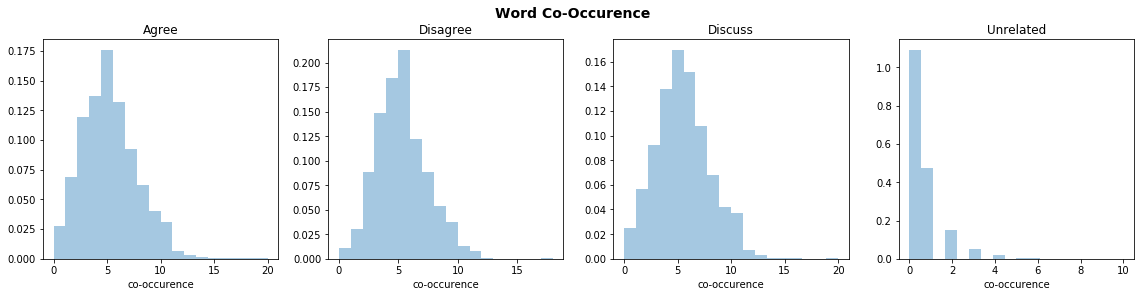

In [83]:
plt.figure(figsize = (16,4))
flag1 = True
flag2 = False

plt.subplot(1,4,1)
sns.distplot(train.loc[train["Stance"] == "agree"]["co-occurence"].dropna(), bins = 18, hist = flag1, kde = flag2, norm_hist = True)
plt.title("Agree")

plt.subplot(1,4,2)
sns.distplot(train.loc[train["Stance"] == "disagree"]["co-occurence"].dropna(), bins = 18, hist = flag1, kde = flag2, norm_hist = True)
plt.title("Disagree")

plt.subplot(1,4,3)
sns.distplot(train.loc[train["Stance"] == "discuss"]["co-occurence"].dropna(), bins = 18, hist = flag1, kde = flag2, norm_hist = True)
plt.title("Discuss")

plt.subplot(1,4,4)
sns.distplot(train.loc[train["Stance"] == "unrelated"]["co-occurence"].dropna(), bins = 18, hist = flag1, kde = flag2, norm_hist = True)
plt.title("Unrelated")

plt.suptitle("Word Co-Occurence", x = 0.5, y = 1.02, fontsize = 14, fontweight="bold")
plt.tight_layout()

Text(0.5,0,'Co-Occurence')

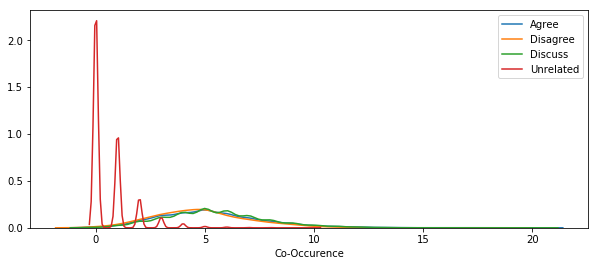

In [84]:
plt.figure(figsize = (10,4))
flag1 = False
flag2 = True

sns.distplot(train.loc[train["Stance"] == "agree"]["co-occurence"].dropna(), hist = flag1, kde = flag2, label = "Agree")
sns.distplot(train.loc[train["Stance"] == "disagree"]["co-occurence"].dropna(), hist = flag1, kde = flag2, label = "Disagree")
sns.distplot(train.loc[train["Stance"] == "discuss"]["co-occurence"].dropna(), hist = flag1, kde = flag2, label = "Discuss")
sns.distplot(train.loc[train["Stance"] == "unrelated"]["co-occurence"].dropna(), hist = flag1, kde = flag2, label = "Unrelated")
plt.xlabel("Co-Occurence")

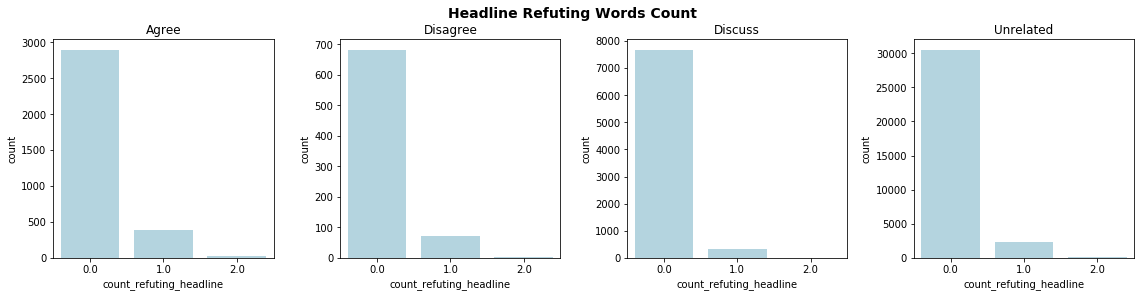

In [85]:
plt.figure(figsize = (16,4))
flag1 = True
flag2 = False

plt.subplot(1,4,1)
sns.countplot(x = train.loc[train["Stance"] == "agree"]["count_refuting_headline"].dropna(), color = "lightblue")
plt.title("Agree")

plt.subplot(1,4,2)
sns.countplot(x = train.loc[train["Stance"] == "disagree"]["count_refuting_headline"].dropna(), color = "lightblue")
plt.title("Disagree")

plt.subplot(1,4,3)
sns.countplot(x = train.loc[train["Stance"] == "discuss"]["count_refuting_headline"].dropna(), color = "lightblue")
plt.title("Discuss")

plt.subplot(1,4,4)
sns.countplot(x = train.loc[train["Stance"] == "unrelated"]["count_refuting_headline"].dropna(), color = "lightblue")
plt.title("Unrelated")

plt.suptitle("Headline Refuting Words Count", x = 0.5, y = 1.02, fontsize = 14, fontweight="bold")
plt.tight_layout()

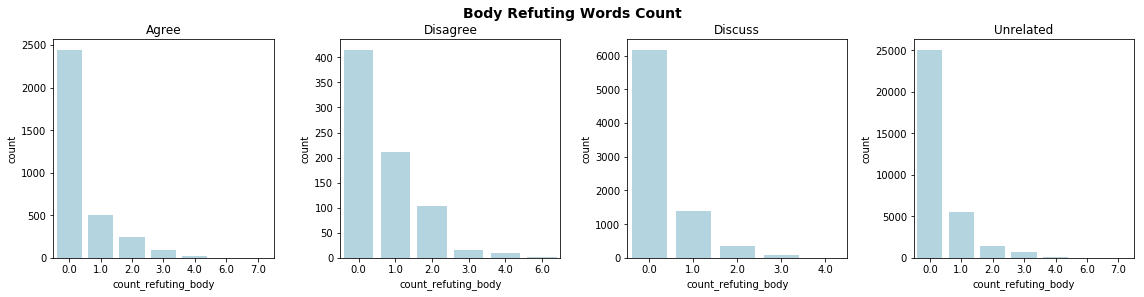

In [86]:
plt.figure(figsize = (16,4))
flag1 = True
flag2 = False

plt.subplot(1,4,1)
sns.countplot(x = train.loc[train["Stance"] == "agree"]["count_refuting_body"].dropna(), color = "lightblue")
plt.title("Agree")

plt.subplot(1,4,2)
sns.countplot(x = train.loc[train["Stance"] == "disagree"]["count_refuting_body"].dropna(), color = "lightblue")
plt.title("Disagree")

plt.subplot(1,4,3)
sns.countplot(x = train.loc[train["Stance"] == "discuss"]["count_refuting_body"].dropna(), color = "lightblue")
plt.title("Discuss")

plt.subplot(1,4,4)
sns.countplot(x = train.loc[train["Stance"] == "unrelated"]["count_refuting_body"].dropna(), color = "lightblue")
plt.title("Unrelated")

plt.suptitle("Body Refuting Words Count", x = 0.5, y = 1.02, fontsize = 14, fontweight="bold")
plt.tight_layout()

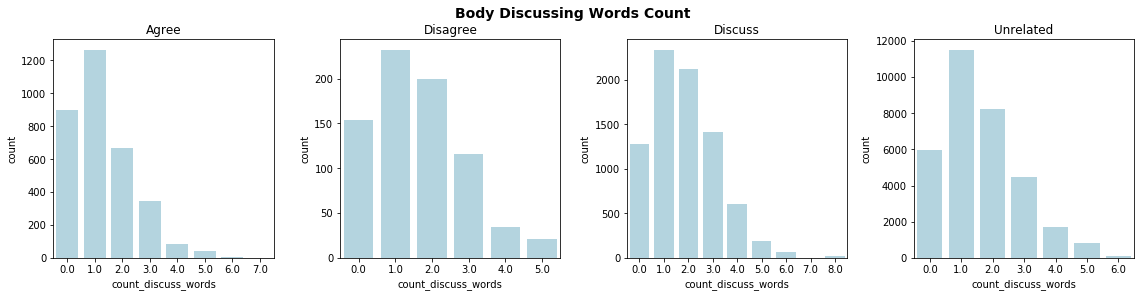

In [87]:
plt.figure(figsize = (16,4))
flag1 = True
flag2 = False

plt.subplot(1,4,1)
sns.countplot(x = train.loc[train["Stance"] == "agree"]["count_discuss_words"].dropna(), color = "lightblue")
plt.title("Agree")

plt.subplot(1,4,2)
sns.countplot(x = train.loc[train["Stance"] == "disagree"]["count_discuss_words"].dropna(), color = "lightblue")
plt.title("Disagree")

plt.subplot(1,4,3)
sns.countplot(x = train.loc[train["Stance"] == "discuss"]["count_discuss_words"].dropna(), color = "lightblue")
plt.title("Discuss")

plt.subplot(1,4,4)
sns.countplot(x = train.loc[train["Stance"] == "unrelated"]["count_discuss_words"].dropna(), color = "lightblue")
plt.title("Unrelated")

plt.suptitle("Body Discussing Words Count", x = 0.5, y = 1.02, fontsize = 14, fontweight="bold")
plt.tight_layout()

In [88]:
train.columns

Index(['Body ID', 'Headline', 'articleBody', 'headlineBody', 'Stance',
       'bow_similarity', 'tfidf_similarity', 'wv_similarity', 'overlap_1',
       'overlap_2', 'overlap_3', 'overlap_4', 'co-occurence', 'refuting',
       'count_refuting_headline', 'count_refuting_body', 'count_discuss_words',
       'headline_polarity', 'headline_subjectivity', 'body_polarity',
       'body_subjectivity', 'bow_euclidean', 'bow_manhattan', 'bow_canberra',
       'tfidf_euclidean', 'tfidf_manhattan', 'tfidf_canberra', 'wv_euclidean',
       'wv_manhattan', 'wv_canberra'],
      dtype='object')

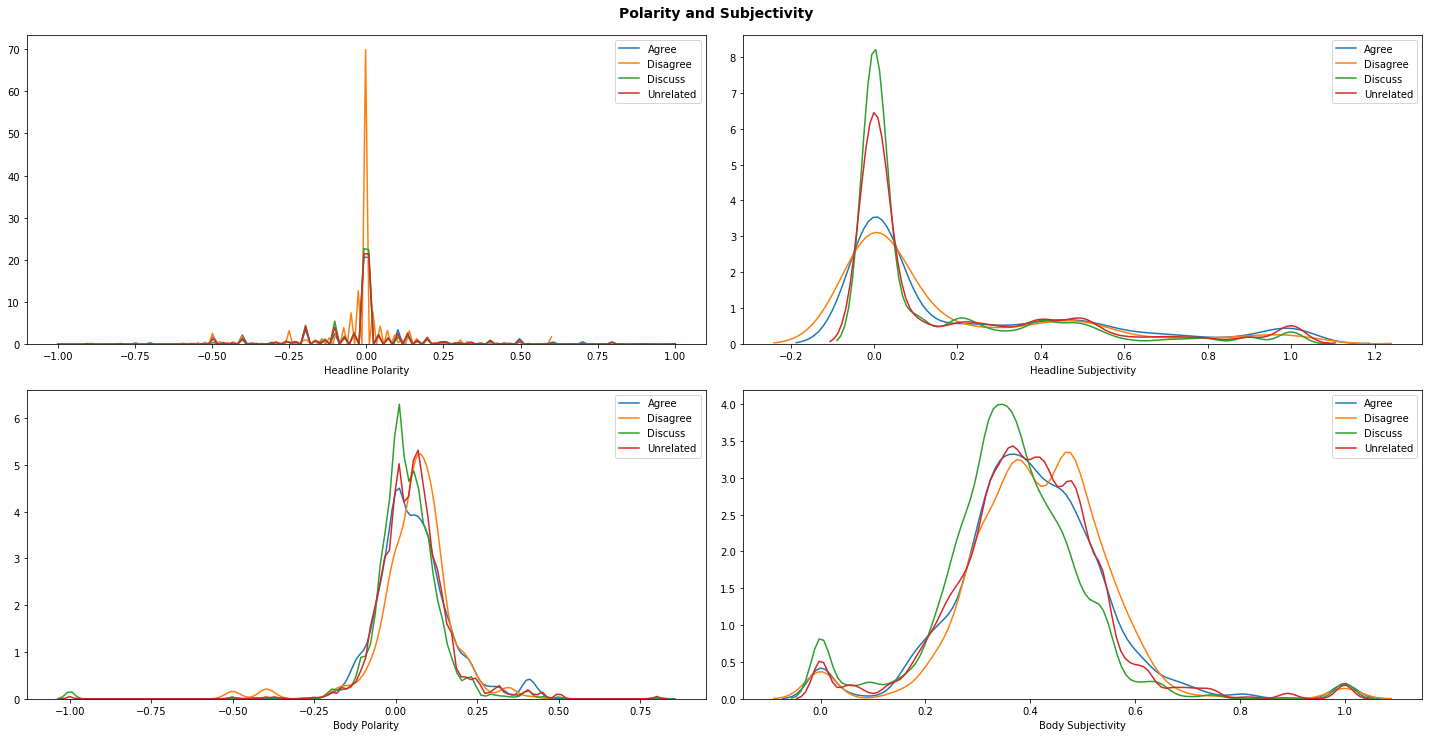

In [89]:
plt.figure(figsize = (20,10))

flag1 = False
flag2 = True

plt.subplot(2,2,1)
sns.distplot(train.loc[train["Stance"] == "agree"]["headline_polarity"].dropna(), hist = flag1, kde = flag2, label = "Agree")
sns.distplot(train.loc[train["Stance"] == "disagree"]["headline_polarity"].dropna(), hist = flag1, kde = flag2, label = "Disagree")
sns.distplot(train.loc[train["Stance"] == "discuss"]["headline_polarity"].dropna(), hist = flag1, kde = flag2, label = "Discuss")
sns.distplot(train.loc[train["Stance"] == "unrelated"]["headline_polarity"].dropna(), hist = flag1, kde = flag2, label = "Unrelated")
plt.xlabel("Headline Polarity")

plt.subplot(2,2,2)
sns.distplot(train.loc[train["Stance"] == "agree"]["headline_subjectivity"].dropna(), hist = flag1, kde = flag2, label = "Agree")
sns.distplot(train.loc[train["Stance"] == "disagree"]["headline_subjectivity"].dropna(), hist = flag1, kde = flag2, label = "Disagree")
sns.distplot(train.loc[train["Stance"] == "discuss"]["headline_subjectivity"].dropna(), hist = flag1, kde = flag2, label = "Discuss")
sns.distplot(train.loc[train["Stance"] == "unrelated"]["headline_subjectivity"].dropna(), hist = flag1, kde = flag2, label = "Unrelated")
plt.xlabel("Headline Subjectivity")

plt.subplot(2,2,3)
sns.distplot(train.loc[train["Stance"] == "agree"]["body_polarity"].dropna(), hist = flag1, kde = flag2, label = "Agree")
sns.distplot(train.loc[train["Stance"] == "disagree"]["body_polarity"].dropna(), hist = flag1, kde = flag2, label = "Disagree")
sns.distplot(train.loc[train["Stance"] == "discuss"]["body_polarity"].dropna(), hist = flag1, kde = flag2, label = "Discuss")
sns.distplot(train.loc[train["Stance"] == "unrelated"]["body_polarity"].dropna(), hist = flag1, kde = flag2, label = "Unrelated")
plt.xlabel("Body Polarity")

plt.subplot(2,2,4)
sns.distplot(train.loc[train["Stance"] == "agree"]["body_subjectivity"].dropna(), hist = flag1, kde = flag2, label = "Agree")
sns.distplot(train.loc[train["Stance"] == "disagree"]["body_subjectivity"].dropna(), hist = flag1, kde = flag2, label = "Disagree")
sns.distplot(train.loc[train["Stance"] == "discuss"]["body_subjectivity"].dropna(), hist = flag1, kde = flag2, label = "Discuss")
sns.distplot(train.loc[train["Stance"] == "unrelated"]["body_subjectivity"].dropna(), hist = flag1, kde = flag2, label = "Unrelated")
plt.xlabel("Body Subjectivity")

plt.suptitle("Polarity and Subjectivity", x = 0.5, y = 1.02, fontsize = 14, fontweight="bold")
plt.tight_layout()

# Q6: Linear and Logistic Regression <a id='question6'></a>

In [90]:
class LinearRegression(object):
    
    """
    Implements Linear Regression using gradient descent
    """
    
    def __init__(self, eta = 0.1, n_iter = 500):
        self.eta = eta
        self.n_iter = n_iter
        
    def fit(self, X, y):
        
        # Number of samples
        N = X.shape[0]
        
        # Intercept term
        intercept = np.ones(X.shape[0])
        
        # Add intercept term to every trainin sample
        X = np.column_stack((intercept, X))
        
        # Initialize weights
        self.w = np.ones(X.shape[1])
        
        # Gradient descent
        for i in range(self.n_iter):
            output = np.dot(X, self.w)
            error = y - output
            self.w += (self.eta / N) * np.dot(error, X)
        
        return self
    
    def predict(self, X):
        # Add interecept
        intercept = np.ones(X.shape[0])
        preds = np.dot(np.column_stack((intercept, X)), self.w)
        return preds

In [91]:
class LogisticRegressionOVR(object):
    
    """
    Implements multiclass Logistic Regression using One-Versus-All method.
    """
    
    def __init__(self, eta = 0.1, n_iter = 500):
        self.eta = eta
        self.n_iter = n_iter
        
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def _log_loss(self, X, y, w):
        
        term1 = y * np.log10(self._sigmoid(np.dot(X,w)))
        term2 = (1-y) * np.log10(1 - self._sigmoid(np.dot(X,w)))
        cost = np.sum(-term1 - term2)
        
        return cost
        
        
    def fit(self, X, y):
        
        # Number of samples
        N = X.shape[0]
        
        # Intercept term
        intercept = np.ones(X.shape[0])
        
        # Add intercept term to every training sample
        X = np.column_stack((intercept, X))
        
        # Initialize weights and loss function
        self.w = []
        self.loss = []
        
        # Gradient descent
        # Iterate through every class
        for label in np.unique(y):
            y_label_i = np.where(y == label, 1, 0)  ## Convert every label of type i to 1 and everything else to 0
            w = np.ones(X.shape[1])
            l_total = []
            
            for _ in range(self.n_iter):
                output = self._sigmoid(np.dot(X, w))
                error = y_label_i - output
                w += (self.eta / N) * np.dot(error, X)
                l_total.append(self._log_loss(X, y_label_i, w))
                
            self.w.append((w,label))
            self.loss.append((l_total, label))
            
        return self
    
    def _predict_single_point(self,x):
        return max((self._sigmoid(np.dot(x,w)), c) for w, c in self.w)[1]
    
    def predict(self, X):
        
        # Add intercept to x
        X = np.column_stack((np.ones(X.shape[0]), X))
        preds = [self._predict_single_point(x) for x in X]
        return preds

### Features

In [92]:
train.columns

Index(['Body ID', 'Headline', 'articleBody', 'headlineBody', 'Stance',
       'bow_similarity', 'tfidf_similarity', 'wv_similarity', 'overlap_1',
       'overlap_2', 'overlap_3', 'overlap_4', 'co-occurence', 'refuting',
       'count_refuting_headline', 'count_refuting_body', 'count_discuss_words',
       'headline_polarity', 'headline_subjectivity', 'body_polarity',
       'body_subjectivity', 'bow_euclidean', 'bow_manhattan', 'bow_canberra',
       'tfidf_euclidean', 'tfidf_manhattan', 'tfidf_canberra', 'wv_euclidean',
       'wv_manhattan', 'wv_canberra'],
      dtype='object')

In [93]:
features_selected = ["bow_similarity", "tfidf_similarity", "overlap_1", "overlap_2", "co-occurence", 
                     "count_refuting_body", "count_discuss_words", "tfidf_euclidean", "Stance"]

In [94]:
train_new = train[features_selected].copy()

In [95]:
train_new.shape

(44974, 9)

In [96]:
train_new.isnull().sum()

bow_similarity         3077
tfidf_similarity       3077
overlap_1                 0
overlap_2                 0
co-occurence              0
count_refuting_body       0
count_discuss_words       0
tfidf_euclidean        3077
Stance                    0
dtype: int64

In [97]:
def fillNA(train_new):
    
    train_new["bow_similarity"] = train_new["bow_similarity"].fillna(train_new["bow_similarity"].dropna().median())
    train_new["tfidf_similarity"] = train_new["tfidf_similarity"].fillna(train_new["tfidf_similarity"].dropna().median())
    train_new["tfidf_euclidean"] = train_new["tfidf_euclidean"].fillna(train_new["tfidf_euclidean"].dropna().median())
    #train_new["tfidf_manhattan"] = train_new["tfidf_manhattan"].fillna(train_new["tfidf_manhattan"].dropna().median())
                
    train_new["Stance_num"] = train_new["Stance"].map({"agree": 1, 
                                                       "disagree": 2,
                                                       "discuss": 3,
                                                       "unrelated": 4})
    
    train_new.drop(["Stance"], axis = 1, inplace = True)
    
    return train_new

In [98]:
train_new = fillNA(train_new)

In [99]:
train_new.columns

Index(['bow_similarity', 'tfidf_similarity', 'overlap_1', 'overlap_2',
       'co-occurence', 'count_refuting_body', 'count_discuss_words',
       'tfidf_euclidean', 'Stance_num'],
      dtype='object')

## Prepare Training Set

In [100]:
X_train = train_new.loc[:, train_new.columns != "Stance_num"].values
y_train = train_new["Stance_num"].values

In [101]:
X_train.shape, y_train.shape

((44974, 8), (44974,))

Let's test if the Logistic Regression Model works properly.

In [102]:
% time lr_ovr = LogisticRegressionOVR(n_iter = 600).fit(X_train, y_train)

CPU times: user 41.4 s, sys: 1min 28s, total: 2min 10s
Wall time: 17.1 s


In [103]:
lr_ovr.w

[(array([-0.97460158,  0.71314683,  0.72793717,  0.96466187,  0.98483531,
          0.29086933,  0.22519988, -0.53803197, -1.56320052]), 1),
 (array([-1.11051128,  0.85953429,  0.85846501,  0.95073508,  0.97956508,
          0.05802547,  0.32334624, -0.63726389, -1.85949462]), 2),
 (array([-0.98968578,  1.07903675,  1.03454896,  0.98664265,  0.97839004,
          0.51087287, -0.2809009 ,  0.05065127, -1.82687844]), 3),
 (array([ 1.33651759,  0.62610453,  0.7673364 ,  0.92360575,  0.98041518,
         -1.66902368,  0.37830924,  0.57614313,  1.66853764]), 4)]

Text(0.5,1,'Cross-Entropy Loss Function')

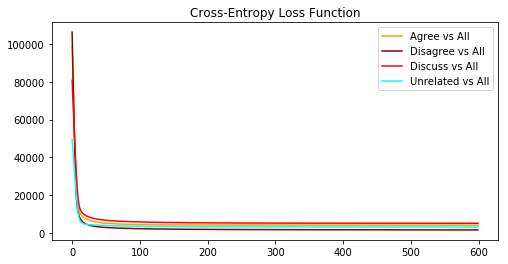

In [104]:
plt.figure(figsize = (8,4))

plt.plot(range(lr_ovr.n_iter), lr_ovr.loss[0][0], color = "orange")
plt.plot(range(lr_ovr.n_iter), lr_ovr.loss[1][0], color = "darkred")
plt.plot(range(lr_ovr.n_iter), lr_ovr.loss[2][0], color = "red")
plt.plot(range(lr_ovr.n_iter), lr_ovr.loss[3][0], color = "cyan")

plt.legend(["Agree vs All", "Disagree vs All", "Discuss vs All", "Unrelated vs All"])
plt.title("Cross-Entropy Loss Function")

### Prepare Validation and Test

In [105]:
validation.columns

Index(['Body ID', 'Headline', 'articleBody', 'headlineBody', 'Stance'], dtype='object')

In [106]:
% time corpus_val_headline = [preprocessText(text) for text in validation["Headline"]]

CPU times: user 2.56 s, sys: 936 ms, total: 3.5 s
Wall time: 25.2 s


In [107]:
% time corpus_val_body = [preprocessText(text) for text in validation["articleBody"]]

CPU times: user 12.4 s, sys: 884 ms, total: 13.3 s
Wall time: 35.1 s


In [108]:
def prepareValidation(validation, corpus_val_headline, corpus_val_body):
    
    # BoW
    bow_val_headline = BoW(corpus = corpus_val_headline, vocabulary = voc)
    bow_val_body = BoW(corpus = corpus_val_body, vocabulary = voc)
    
    #Tf-Idf
    tfidf_val_headline = tfidf(corpus = corpus_val_headline, vocabulary = voc)
    tfidf_val_body = tfidf(corpus = corpus_val_body, vocabulary = voc)
    
    # Bow related features
    validation["bow_similarity"] = calculateSimilarity(bow_val_headline, bow_val_body, cosineSimilarity)
    validation["bow_euclidean"] = calculateSimilarity(bow_val_headline, bow_val_body, euclideanDistance)
    validation["bow_manhattan"] = calculateSimilarity(bow_val_headline, bow_val_body, manhattanDistance)
    validation["bow_canberra"] = calculateSimilarity(bow_val_headline, bow_val_body, canberraDistance)
    
    # Tf-idf related features
    validation["tfidf_similarity"] = calculateSimilarity(tfidf_val_headline, tfidf_val_body, cosineSimilarity)
    validation["tfidf_euclidean"] = calculateSimilarity(tfidf_val_headline, tfidf_val_body, euclideanDistance)
    validation["tfidf_manhattan"] = calculateSimilarity(tfidf_val_headline, tfidf_val_body, manhattanDistance)
    validation["tfidf_canberra"] = calculateSimilarity(tfidf_val_headline, tfidf_val_body, canberraDistance)
    
    # Global features
    # Overlapping ngrams
    validation["overlap_1"] = ngramOverlap(corpus_val_headline, corpus_val_body, 1)
    validation["overlap_2"] = ngramOverlap(corpus_val_headline, corpus_val_body, 2)
    validation["overlap_3"] = ngramOverlap(corpus_val_headline, corpus_val_body, 3)
    validation["overlap_4"] = ngramOverlap(corpus_val_headline, corpus_val_body, 4)
    
    # Co-occurence
    validation["co-occurence"] = co_occurenceSum(corpus_val_headline, corpus_val_body)
    
    # Refuting words
    validation["refuting"] = refutingWords(corpus_val_headline)
    
    # Count refuting words
    validation["count_refuting_headline"] = countRefutingWords(corpus_val_headline) 
    validation["count_refuting_body"] = countRefutingWords(corpus_val_body)
    
    # Discuss words
    validation["count_discuss_words"] = countDiscussWords(corpus_val_body)
    
    return validation

In [109]:
% time validation = prepareValidation(validation, corpus_val_headline, corpus_val_body)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:69: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:12: DeprecationWarning: generator 'ngrams' raised StopIteration


CPU times: user 14.1 s, sys: 44 ms, total: 14.1 s
Wall time: 14.1 s


In [110]:
validation_new = validation.copy()[features_selected]
validation_new = fillNA(validation_new)

In [111]:
X_validation = validation_new.loc[:, validation_new.columns != "Stance_num"].values
y_validation = validation_new["Stance_num"].values

In [112]:
X_validation.shape, y_validation.shape

((4998, 8), (4998,))

### Test Set

In [113]:
# Join datasets
test = pd.merge(test_stances, test_bodies, on = "Body ID", how = "left")

In [114]:
test.columns

Index(['Headline', 'Body ID', 'Stance', 'articleBody'], dtype='object')

In [115]:
test.shape

(25413, 4)

In [116]:
% time corpus_test_headline = [preprocessText(text) for text in test["Headline"]]

CPU times: user 12.2 s, sys: 4.26 s, total: 16.5 s
Wall time: 2min 6s


In [117]:
% time corpus_test_body = [preprocessText(text) for text in test["articleBody"]]

CPU times: user 1min, sys: 4.04 s, total: 1min 4s
Wall time: 2min 57s


In [118]:
% time test = prepareValidation(test, corpus_test_headline, corpus_test_body)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:69: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:12: DeprecationWarning: generator 'ngrams' raised StopIteration


CPU times: user 1min 7s, sys: 316 ms, total: 1min 8s
Wall time: 1min 8s


In [119]:
test.shape

(25413, 21)

In [120]:
test.columns

Index(['Headline', 'Body ID', 'Stance', 'articleBody', 'bow_similarity',
       'bow_euclidean', 'bow_manhattan', 'bow_canberra', 'tfidf_similarity',
       'tfidf_euclidean', 'tfidf_manhattan', 'tfidf_canberra', 'overlap_1',
       'overlap_2', 'overlap_3', 'overlap_4', 'co-occurence', 'refuting',
       'count_refuting_headline', 'count_refuting_body',
       'count_discuss_words'],
      dtype='object')

In [121]:
test.isnull().sum()

Headline                      0
Body ID                       0
Stance                        0
articleBody                   0
bow_similarity             2737
bow_euclidean                 0
bow_manhattan                 0
bow_canberra                  0
tfidf_similarity           2737
tfidf_euclidean            2737
tfidf_manhattan            2737
tfidf_canberra                0
overlap_1                     0
overlap_2                     0
overlap_3                     0
overlap_4                     0
co-occurence                  0
refuting                      0
count_refuting_headline       0
count_refuting_body           0
count_discuss_words           0
dtype: int64

In [122]:
test_new = test.copy()[features_selected]
test_new = fillNA(test_new)

In [123]:
X_test = test_new.loc[:, test_new.columns != "Stance_num"].values
y_test = test_new["Stance_num"].values

In [124]:
X_test.shape, y_test.shape

((25413, 8), (25413,))

# Q7. Model Evaluation <a id='question7'></a>

In [125]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [126]:
def accuracy_score(y_pred, y):
    return np.sum(y_pred == y) / len(y)

In [127]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          bar = True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True.
    (Code taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
#     fig, ax = subplots(figsize=(15, 6))
#     ax.imshow(cm, interpolation='nearest', cmap=cmap)
#     ax.set_title(title)
#     if bar:
#         plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     ax.set_xticks(tick_marks, classes, rotation=45)
#     ax.set_yticks(tick_marks, classes)

#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')                  
#     plt.xlabel('Predicted label')
                       
    fig = plt.figure(figsize = (20,4))                  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    if bar:
        plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## (FNC-1 Baseline)

In [128]:
LABELS = ['agree', 'disagree', 'discuss', 'unrelated']
LABELS_RELATED = ['unrelated','related']
RELATED = LABELS[0:3]

def score_submission(gold_labels, test_labels):
    score = 0.0
    cm = [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]]

    for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance != 'unrelated':
                score += 0.50
        if g_stance in RELATED and t_stance in RELATED:
            score += 0.25

        cm[LABELS.index(g_stance)][LABELS.index(t_stance)] += 1

    return score, cm


def print_confusion_matrix(cm):
    lines = []
    header = "|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format('', *LABELS)
    line_len = len(header)
    lines.append("-"*line_len)
    lines.append(header)
    lines.append("-"*line_len)

    hit = 0
    total = 0
    for i, row in enumerate(cm):
        hit += row[i]
        total += sum(row)
        lines.append("|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format(LABELS[i],
                                                                   *row))
        lines.append("-"*line_len)
    print('\n'.join(lines))


def report_score(actual,predicted, verbose = True):
    score,cm = score_submission(actual,predicted)
    best_score, _ = score_submission(actual,actual)
    
    if verbose:
        print_confusion_matrix(cm)
        print("Score: " +str(score) + " out of " + str(best_score) + "\t("+str(score*100/best_score) + "%)")
    return score*100/best_score

### Linear Regression

Linear Regression is used to predict a continuous variable. In the stance detection problem we need to predict a category, therefore LineR Regression cannot be used for such a task. However, as the assignment asks, we will use the Linear Regression model, just to proove its unsuitability.

In [129]:
linear_regr = LinearRegression().fit(X_train, y_train)

In [130]:
linear_regr_preds = linear_regr.predict(X_validation)

In [131]:
# try:
#     classification_report(y_validation, linear_regr_preds, target_names = labels)
# except ValueError as e:
#     print(e)

In [132]:
linear_regr_score = accuracy_score(y_validation, linear_regr_preds)
linear_regr_score

0.0

As we see we get a 0 accuracy, which is absolutely expected, since Linear Regression generates continuous output. We proceed with Logistic Regression.

### Logistic Regression

In [133]:
lr_preds = lr_ovr.predict(X_validation)

In [134]:
labels = ["Agree", "Disagree", "Discuss", "Unrelated"]
print(classification_report(y_validation, lr_preds, target_names = labels))

             precision    recall  f1-score   support

      Agree       0.25      0.00      0.01       368
   Disagree       0.00      0.00      0.00        84
    Discuss       0.64      0.79      0.70       891
  Unrelated       0.93      0.99      0.96      3655

avg / total       0.81      0.86      0.82      4998



/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [135]:
actual = y_validation
predicted = lr_preds

score = report_score([LABELS[e-1] for e in actual],[LABELS[e-1] for e in predicted])

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     1     |     0     |    285    |    82     |
-------------------------------------------------------------
| disagree  |     1     |     0     |    65     |    18     |
-------------------------------------------------------------
|  discuss  |     2     |     0     |    703    |    186    |
-------------------------------------------------------------
| unrelated |     0     |     0     |    51     |   3604    |
-------------------------------------------------------------
Score: 1693.25 out of 2256.75	(75.03046416306636%)


In [136]:
validation["Stance"].value_counts()

unrelated    3655
discuss       891
agree         368
disagree       84
Name: Stance, dtype: int64

## Use Validation to tune learning rate

In [137]:
learning_rate = np.hstack((np.linspace(0.001, 1, 60), np.linspace(1.001, 5, 40)))

In [138]:
scores = []
i = 0
start = time.time()

for a in learning_rate:
    
    lr = LogisticRegressionOVR(eta = a, n_iter = 500).fit(X_train, y_train)
    preds = lr.predict(X_validation)
    scores.append(report_score([LABELS[e-1] for e in y_validation],[LABELS[e-1] for e in preds], verbose = False))
    
    if i and i % 5 == 0:
        print("Iterations {} / {} completed".format(i, len(learning_rate)))
    i+=1
    
end = time.time()
print("Execution Time: {}".format((end - start) / 60))

Iterations 5 / 100 completed
Iterations 10 / 100 completed
Iterations 15 / 100 completed
Iterations 20 / 100 completed
Iterations 25 / 100 completed
Iterations 30 / 100 completed
Iterations 35 / 100 completed
Iterations 40 / 100 completed
Iterations 45 / 100 completed
Iterations 50 / 100 completed
Iterations 55 / 100 completed
Iterations 60 / 100 completed
Iterations 65 / 100 completed


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10


Iterations 70 / 100 completed


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in multiply


Iterations 75 / 100 completed
Iterations 80 / 100 completed
Iterations 85 / 100 completed
Iterations 90 / 100 completed
Iterations 95 / 100 completed
Execution Time: 25.85546881755193


In [139]:
#scores = joblib.load("eta_scores.pkl")

In [140]:
#joblib.dump(scores, "eta_scores.pkl")

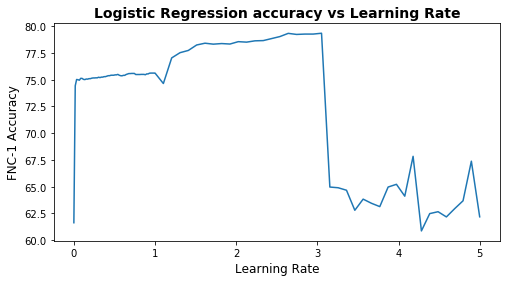

In [141]:
plt.figure(figsize = (8,4))

plt.plot(learning_rate, scores)
plt.xlabel("Learning Rate", fontsize = 12)
plt.ylabel("FNC-1 Accuracy", fontsize = 12)
plt.title("Logistic Regression accuracy vs Learning Rate", fontsize = 14, fontweight = "bold")
#plt.savefig("Figures/eta.png")

In [142]:
learning_rate[np.argmax(scores)]

3.0517692307692306

In [143]:
best_lr_model = LogisticRegressionOVR(eta = learning_rate[np.argmax(scores)])
best_lr_model

In [144]:
% time best_lr_model.fit(X_train, y_train)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in multiply


CPU times: user 36.3 s, sys: 1min 13s, total: 1min 49s
Wall time: 15.6 s


In [145]:
lr_preds_validation = best_lr_model.predict(X_validation)

In [146]:
test_actual = y_validation
test_predicted = lr_preds_validation

lr_validation_score = report_score([LABELS[e-1] for e in test_actual],[LABELS[e-1] for e in test_predicted])

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     6     |     0     |    326    |    36     |
-------------------------------------------------------------
| disagree  |     0     |     0     |    74     |    10     |
-------------------------------------------------------------
|  discuss  |    10     |     0     |    807    |    74     |
-------------------------------------------------------------
| unrelated |     2     |     0     |    153    |   3500    |
-------------------------------------------------------------
Score: 1790.5 out of 2256.75	(79.33975850227097%)


In [147]:
lr_preds_test = best_lr_model.predict(X_test)

In [148]:
test_actual = y_test
test_predicted = lr_preds_test

lr_test_score = report_score([LABELS[e-1] for e in test_actual],[LABELS[e-1] for e in test_predicted])

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    22     |     0     |   1688    |    193    |
-------------------------------------------------------------
| disagree  |    13     |     0     |    508    |    176    |
-------------------------------------------------------------
|  discuss  |    53     |     0     |   3950    |    461    |
-------------------------------------------------------------
| unrelated |    11     |     0     |    612    |   17726   |
-------------------------------------------------------------
Score: 8969.0 out of 11651.25	(76.97886492865572%)


In [149]:
print(classification_report(y_test, lr_preds_test, target_names = labels))

             precision    recall  f1-score   support

      Agree       0.22      0.01      0.02      1903
   Disagree       0.00      0.00      0.00       697
    Discuss       0.58      0.88      0.70      4464
  Unrelated       0.96      0.97      0.96     18349

avg / total       0.81      0.85      0.82     25413



/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [150]:
validation_results = pd.DataFrame(index = ["Validation Set", "Test Set"],
                                  columns = ["FNC-1 Accuracy", "Weighted F1", "F1-Agree", "F1-Disagree", "F1-Discuss", "F1-Unrelated"])

validation_results.loc["Validation Set"]["FNC-1 Accuracy"] = lr_validation_score 
validation_results.loc["Validation Set"]["Weighted F1"] = f1_score(y_validation, lr_preds_validation, average = "weighted") 
validation_results.loc["Validation Set"]["F1-Agree"] = f1_score(y_validation, lr_preds_validation, average = None)[0] 
validation_results.loc["Validation Set"]["F1-Disagree"] = f1_score(y_validation, lr_preds_validation, average = None)[1]  
validation_results.loc["Validation Set"]["F1-Discuss"] = f1_score(y_validation, lr_preds_validation, average = None)[2]  
validation_results.loc["Validation Set"]["F1-Unrelated"] = f1_score(y_validation, lr_preds_validation, average = None)[3]  

validation_results.loc["Test Set"]["FNC-1 Accuracy"] = lr_test_score 
validation_results.loc["Test Set"]["Weighted F1"] = f1_score(y_test, lr_preds_test, average = "weighted") 
validation_results.loc["Test Set"]["F1-Agree"] = f1_score(y_test, lr_preds_test, average = None)[0] 
validation_results.loc["Test Set"]["F1-Disagree"] = f1_score(y_test, lr_preds_test, average = None)[1]  
validation_results.loc["Test Set"]["F1-Discuss"] = f1_score(y_test, lr_preds_test, average = None)[2]  
validation_results.loc["Test Set"]["F1-Unrelated"] = f1_score(y_test, lr_preds_test,average = None)[3]  

# validation_results.loc["Validation Set"] = [lr_validation_score,
#                                            f1_score(y_validation, lr_preds_validation, average = "weighted"),
#                                            ]

validation_results = validation_results.transpose()
validation_results.to_latex("Figures/lr.tex")

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [151]:
validation_results

,Validation Set,Test Set
FNC-1 Accuracy,79.3398,76.9789
Weighted F1,0.833761,0.818909
F1-Agree,0.0310881,0.021978
F1-Disagree,0,0
F1-Discuss,0.717015,0.703974
F1-Unrelated,0.962199,0.960629


Confusion matrix, without normalization
[[   6    0  326   36]
 [   0    0   74   10]
 [  10    0  807   74]
 [   2    0  153 3500]]


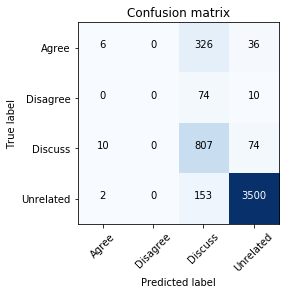

In [152]:
plt.figure(figsize = (15,9))
plot_confusion_matrix(confusion_matrix(y_validation, lr_preds_validation), classes = labels, bar = False)
#plt.savefig("Figures/lr1.png")

Confusion matrix, without normalization
[[   22     0  1688   193]
 [   13     0   508   176]
 [   53     0  3950   461]
 [   11     0   612 17726]]


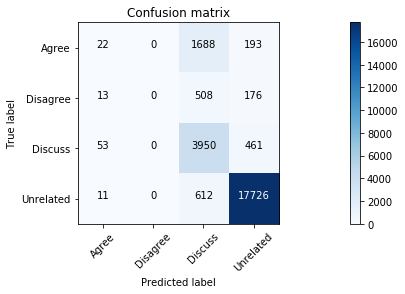

In [153]:
plt.figure(figsize = (10,4))
plot_confusion_matrix(confusion_matrix(y_test, lr_preds_test), classes = labels, bar = True)
#plt.savefig("Figures/lr2.png")

In [154]:
test["Stance"].value_counts()

unrelated    18349
discuss       4464
agree         1903
disagree       697
Name: Stance, dtype: int64

# Q8. Feature Importance <a id='question8'></a>

In [155]:
df_weights = pd.DataFrame(columns = ["Feature", "Weight1", "Weight2", "Weight3", "Weight4"])
df_weights["Feature"] = train_new.columns[:-1]
df_weights["Weight1"] = best_lr_model.w[0][0][1:]
df_weights["Weight2"] = best_lr_model.w[1][0][1:]
df_weights["Weight3"] = best_lr_model.w[2][0][1:]
df_weights["Weight4"] = best_lr_model.w[3][0][1:]

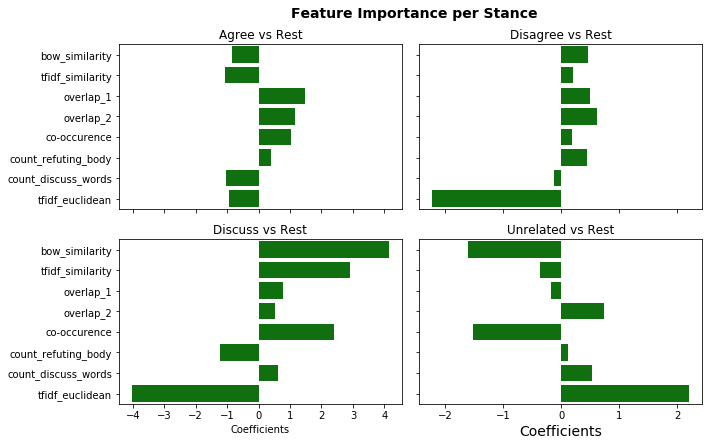

In [156]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols = 2, nrows = 2, sharex = "col", sharey="row", figsize = (10,6))

sns.barplot(y = "Feature", x = "Weight1", data = df_weights, color = "green", ax = ax1)
ax1.set_title('Agree vs Rest')
ax1.set_ylabel("")
ax1.set_xlabel("")

sns.barplot(y = "Feature", x = "Weight2", data = df_weights, color = "green", ax = ax2)
ax2.set_title('Disagree vs Rest')
ax2.set_ylabel("")
ax2.set_xlabel("")

sns.barplot(y = "Feature", x = "Weight3", data = df_weights, color = "green", ax = ax3)
ax3.set_title('Discuss vs Rest')
ax3.set_ylabel("")
ax3.set_xlabel("Coefficients")

sns.barplot(y = "Feature", x = "Weight4", data = df_weights, color = "green", ax = ax4)
ax4.set_title('Unrelated vs Rest')
ax4.set_ylabel("")
ax4.set_xlabel("Coefficients", fontsize = 14)

plt.suptitle("Feature Importance per Stance", fontsize = 14, fontweight = "bold", x = 0.58, y = 1.025)
plt.tight_layout()
#plt.savefig("Figures/feat_import.png")

# Q9. Model Improvement <a id='question9'></a>

In [157]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

## Oversampling

In [158]:
from imblearn.over_sampling import SMOTE

In [159]:
train["Stance"].value_counts()

unrelated    32890
discuss       8018
agree         3310
disagree       756
Name: Stance, dtype: int64

In [160]:
sm = SMOTE(ratio = dict({1: 5000, 2: 3000, 3: 10000, 4: train["Stance"].value_counts()[0]}), random_state = 123)

In [161]:
% time X_train_resampled, y_train_resampled = sm.fit_sample(X_train, y_train)

CPU times: user 280 ms, sys: 20 ms, total: 300 ms
Wall time: 276 ms


In [162]:
X_train_resampled.shape, y_train_resampled.shape

((50890, 8), (50890,))

In [163]:
Counter(y_train_resampled)

Counter({1: 5000, 2: 3000, 3: 10000, 4: 32890})

In [164]:
def evaluateScikitModels(clf, resampling = False):
    
    """
    This function takes as input a list of classifiers, trains each classifier on training data and returns 
    confution matrix and accuracy (as defined by the official evaluation metric from FNC-1 Baseline)
    for both validation and test sets.
    """
    
    # Initialize dataframe to store results
    results = pd.DataFrame(columns = ["Classifier", "Set", "Parameters", "Accuracy", "Weighted F1-score",
                                      "Agree F1", "Disagree F1", "Discuss F1", "Unrelated F1", "Predictions"])
    i = 0
    
    for model in clf:
        
        # Fit
        if resampling:
            % time model.fit(X_train_resampled, y_train_resampled)
        else:
            % time model.fit(X_train, y_train)
    
        # Evaluate on validation set
        val_preds = model.predict(X_validation)
        print("Classifier \033[1m {}, validation \033[0mset performance:".format(model.__module__))
        print("\n")
        val_score = np.round(report_score([LABELS[e-1] for e in y_validation],[LABELS[e-1] for e in val_preds]), 2)
        f1_total = np.round(f1_score(y_validation, val_preds, average = "weighted")*100, 2)
        f1_agree = np.round(f1_score(y_validation, val_preds, average = None)[0]*100, 2)
        f1_disagree = np.round(f1_score(y_validation, val_preds, average = None)[1]*100, 2)
        f1_discuss = np.round(f1_score(y_validation, val_preds, average = None)[2]*100, 2)
        f1_unrelated = np.round(f1_score(y_validation, val_preds, average = None)[3]*100, 2)
        results.loc[i] = [model.__module__, "Validation", model.get_params(), val_score, f1_total, 
                          f1_agree, f1_disagree, f1_discuss, f1_unrelated, val_preds]
        i+=1

        # Evaluate on test set
        test_preds = model.predict(X_test)
        print("Classifier \033[1m {}, test \033[0mset performance:".format(model.__module__))
        print("\n")
        test_score = np.round(report_score([LABELS[e-1] for e in y_test],[LABELS[e-1] for e in test_preds]), 2)
        f1_total = np.round(f1_score(y_test, test_preds, average = "weighted")*100,2)
        f1_agree = np.round(f1_score(y_test, test_preds, average = None)[0]*100, 2)
        f1_disagree = np.round(f1_score(y_test, test_preds, average = None)[1]*100, 2)
        f1_discuss = np.round(f1_score(y_test, test_preds, average = None)[2]*100, 2)
        f1_unrelated = np.round(f1_score(y_test, test_preds, average = None)[3]*100, 2)
        results.loc[i] = [model.__module__, "Test", model.get_params(), test_score, f1_total, 
                          f1_agree, f1_disagree, f1_discuss, f1_unrelated, test_preds]
        i+=1
        print("--------------------------------------------------------------------------")
        print("--------------------------------------------------------------------------")
        
        
    return results

In [165]:
classifiers = [RandomForestClassifier(n_estimators = 500, max_depth = 7, random_state = 123),
               XGBClassifier(n_estimators = 500, random_state = 123),
               MLPClassifier(hidden_layer_sizes = (256, 64, 32), activation = "logistic", random_state = 123)
              ]

In [166]:
res_no_over = evaluateScikitModels(classifiers, resampling = False)

CPU times: user 11.2 s, sys: 0 ns, total: 11.2 s
Wall time: 11.2 s
Classifier  sklearn.ensemble.forest, validation set performance:


-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    64     |     0     |    276    |    28     |
-------------------------------------------------------------
| disagree  |    15     |     0     |    60     |     9     |
-------------------------------------------------------------
|  discuss  |    35     |     0     |    778    |    78     |
-------------------------------------------------------------
| unrelated |     0     |     0     |    64     |   3591    |
-------------------------------------------------------------
Score: 1836.25 out of 2256.75	(81.36701008086851%)


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Classifier  sklearn.ensemble.forest, test set performance:


-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    247    |     0     |   1481    |    175    |
-------------------------------------------------------------
| disagree  |    62     |     0     |    486    |    149    |
-------------------------------------------------------------
|  discuss  |    371    |     0     |   3643    |    450    |
-------------------------------------------------------------
| unrelated |     7     |     0     |    385    |   17957   |
-------------------------------------------------------------
Score: 8979.25 out of 11651.25	(77.06683832206845%)
--------------------------------------------------------------------------
--------------------------------------------------------------------------


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


CPU times: user 33.5 s, sys: 0 ns, total: 33.5 s
Wall time: 33.5 s


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Classifier  xgboost.sklearn, validation set performance:


-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    94     |     0     |    251    |    23     |
-------------------------------------------------------------
| disagree  |    17     |     3     |    55     |     9     |
-------------------------------------------------------------
|  discuss  |    57     |     0     |    760    |    74     |
-------------------------------------------------------------
| unrelated |     2     |     0     |    53     |   3600    |
-------------------------------------------------------------
Score: 1852.0 out of 2256.75	(82.06491636202503%)


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Classifier  xgboost.sklearn, test set performance:


-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    346    |     5     |   1396    |    156    |
-------------------------------------------------------------
| disagree  |    96     |     3     |    457    |    141    |
-------------------------------------------------------------
|  discuss  |    513    |     6     |   3505    |    440    |
-------------------------------------------------------------
| unrelated |    24     |     0     |    366    |   17959   |
-------------------------------------------------------------
Score: 8962.0 out of 11651.25	(76.9187855380324%)
--------------------------------------------------------------------------
--------------------------------------------------------------------------
CPU times: user 1min 9s, sys: 2min 1s, total: 3min 10s
Wall time:

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Classifier  sklearn.neural_network.multilayer_perceptron, test set performance:


-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    317    |     0     |   1359    |    227    |
-------------------------------------------------------------
| disagree  |    139    |     0     |    377    |    181    |
-------------------------------------------------------------
|  discuss  |    545    |     0     |   3376    |    543    |
-------------------------------------------------------------
| unrelated |    21     |     0     |    333    |   17995   |
-------------------------------------------------------------
Score: 8796.75 out of 11651.25	(75.5004827808175%)
--------------------------------------------------------------------------
--------------------------------------------------------------------------


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [167]:
res_over = evaluateScikitModels(classifiers, resampling = True)

CPU times: user 14.1 s, sys: 0 ns, total: 14.1 s
Wall time: 14.1 s
Classifier  sklearn.ensemble.forest, validation set performance:


-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    81     |     5     |    257    |    25     |
-------------------------------------------------------------
| disagree  |    16     |     7     |    53     |     8     |
-------------------------------------------------------------
|  discuss  |    51     |     3     |    771    |    66     |
-------------------------------------------------------------
| unrelated |     0     |     0     |    76     |   3579    |
-------------------------------------------------------------
Score: 1850.0 out of 2256.75	(81.97629334219563%)
Classifier  sklearn.ensemble.forest, test set performance:


-------------------------------------------------------------
|          

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Classifier  xgboost.sklearn, validation set performance:


-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    107    |    25     |    215    |    21     |
-------------------------------------------------------------
| disagree  |    16     |    21     |    41     |     6     |
-------------------------------------------------------------
|  discuss  |    72     |    33     |    720    |    66     |
-------------------------------------------------------------
| unrelated |     4     |     2     |    56     |   3593    |
-------------------------------------------------------------
Score: 1846.75 out of 2256.75	(81.83228093497286%)


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Classifier  xgboost.sklearn, test set performance:


-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    425    |    60     |   1281    |    137    |
-------------------------------------------------------------
| disagree  |    116    |    43     |    407    |    131    |
-------------------------------------------------------------
|  discuss  |    754    |    81     |   3220    |    409    |
-------------------------------------------------------------
| unrelated |    50     |    26     |    373    |   17900   |
-------------------------------------------------------------
Score: 8837.75 out of 11651.25	(75.8523763544684%)
--------------------------------------------------------------------------
--------------------------------------------------------------------------
CPU times: user 3min 49s, sys: 6min 30s, total: 10min 19s
Wall t

In [168]:
res_no_over["Oversampling"] = 0
res_over["Oversampling"] = 1

In [169]:
#pd.concat([res_no_over, res_over])

In [170]:
final_results = pd.concat([res_no_over, res_over])[["Classifier", "Set", "Oversampling", "Accuracy", "Weighted F1-score",
                                                    "Agree F1", "Disagree F1", "Discuss F1", "Unrelated F1"]]
final_results["Classifier"] = ["Random Forest", "Random Forest", "XGBoost", "XGBoost", "MLP", "MLP",
                               "Random Forest", "Random Forest", "XGBoost", "XGBoost", "MLP", "MLP"]
final_results

,Classifier,Set,Oversampling,Accuracy,Weighted F1-score,Agree F1,Disagree F1,Discuss F1,Unrelated F1
0,Random Forest,Validation,0,81.37,86.71,26.56,0.00,75.21,97.57
1,Random Forest,Test,0,77.07,83.60,19.07,0.00,69.66,96.86
2,XGBoost,Validation,0,82.06,87.70,34.94,6.90,75.62,97.81
3,XGBoost,Test,0,76.92,83.91,24.01,0.84,68.81,96.96
4,MLP,Validation,0,79.32,85.57,24.00,0.00,72.92,96.82
5,MLP,Test,0,75.50,83.27,21.68,0.00,68.14,96.50
0,Random Forest,Validation,1,81.98,87.36,31.40,14.14,75.29,97.61
1,Random Forest,Test,1,76.53,83.53,22.24,0.56,67.71,96.88
2,XGBoost,Validation,1,81.83,88.14,37.74,25.45,74.88,97.89
3,XGBoost,Test,1,75.85,83.83,26.17,9.48,66.09,96.95


In [171]:
end_total = time.time()

In [172]:
print("Notebook total execution time: {}".format((end_total - start_total) / 60))

Notebook total execution time: 60.506812425454456


In [1]:
76.53-75.20

1.3299999999999983

In [2]:
81.83 - 79.53

2.299999999999997